# Spinal cord injury analysis

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

## Dataset

The data comes from the National Spinal Cord Injury Statistical Center (NSCISC).

Unpack it a `data` directory as follows for scripts to find it:
```
data
├── f1_public_2021.csv
└── f2_public_2021.csv
```

The two files contain responses to two forms, f1 and f2. The first form is administered at injury time. The second is recurring, first one year after the injury, then five, then every five years after this.

The vast majority of columns are categories whose definitions are given in a data dictionary, but we keep them as strings and integers for now to facilitate computations. The columns explicitely listed below contain a mix of integers and strings (e.g. `32` and `"6-12y"`) so we import them as strings to avoid warnings.

In [2]:
df1 = pd.read_csv(
    "data/f1_public_2021.csv",
    dtype={col_name: str for col_name in ['AExtCsIj', 'AASAImAd', 'AASAImDs', 'AInjAge']},
)
df2 = pd.read_csv(
    "data/f2_public_2021.csv",
    dtype={col_index: str for col_index in ['BASAImp']},
)

The two forms have a single column in common, a unique ID per patient called `UniID`, so we can merge them into a single long-form dataframe.

In [3]:
df = pd.merge(df2, df1, on='UniID', how='left')

Let's look at how many records we're starting with:

In [4]:
df1.shape[0], df2.shape[0], df.shape[0]

(35675, 131217, 131217)

## Research questions

We'd like to answer the following questions:

1. Do people with high functional scores still report low engagement in leisure or screen-based activities?
2. Do higher depression scores correlate with lower leisure/screen engagement?
3. Are younger people more likely to engage in screen-based leisure?
4. Do mobility users report lower participation?
5. Is lower income associated with reduced leisure and higher depression?

To do that, we have to identify the relevant columns and compute some aggregated scores.

### Functionality

Let's start with functional scores.

In [5]:
functional_columns = {
    'ACrEat': 'Self-Care A. Eating',
    'ACrOrl': 'Self-Care B. Oral Hygiene',
    'ACrTlHy': 'Self-Care C. Toileting hygiene',
    'ACrShr': 'Self-Care E. Shower/bathe self',
    'ACrUpDr': 'Self-Care F. Upper body dressing',
    'ACrLrDr': 'Self-Care G. Lower body dressing',
    'ACrFtr': 'Self-Care H. Putting on/taking off footwear',
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}

All these columns correspond to functional scores and share the same response category.

In [6]:
functional_category = {
  1: 'Dependent',
  2: 'Substantial/maximal assistance',
  3: 'Partial/moderate assistance',
  4: 'Supervision or Touching Assistance',
  5: 'Setup or clean-up assistance',
  6: 'Independent',
  7: 'Patient Refused',
  9: 'Not applicable',
  10: 'Not attempted due to environmental limitations',
  88: 'Not attempted due to medical condition or safety concerns',
  99: 'Unknown, No rehab admit',
}

Note that for this manually computed metric we exclude:
- `ACrCh`: Wheel Q. Does patient use wheelchair/scooter
- `ACrT50`: Wheel RR Type of wheelchair/scooter used
- `ACrT150`: Wheel SS 150 Ft Type of wheelchair/scooter used

even though they are functional responses in the same group because they use a different category (yes/no).

Also note that each column actually maps to two columns because the same questions get evaluated twice, once at the start of rehab and once at discharge. They're differentiated by the suffixes `R` and `D`.

In [7]:
functional_columns = [f'{key}{suffix}' for key in functional_columns.keys() for suffix in ['R', 'D']]

Next we can compute the average functional score. Since it's only using data from form 1, we prefix the new column with `A` for consistency.

We must be careful to exclude invalid values.

In [8]:
df1['AFunctionalScore'] = df1[functional_columns][df1[functional_columns] < 7].dropna(how='all', axis=0).mean(axis=1)

Let's add that new colum to `df`.

In [9]:
df = pd.merge(df, df1[['UniID', 'AFunctionalScore']], on='UniID', how='left')

How many rows did we drop for lack of any functional scores?

In [10]:
(
    df1.dropna(subset='AFunctionalScore').shape[0],
    df1.dropna(subset='AFunctionalScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalScore').shape[0],
    df.dropna(subset='AFunctionalScore').shape[0] / df.shape[0],
)
# (3249, 0.09107217939733707, 2215, 0.016880434699772132)

(3249, 0.09107217939733707, 2215, 0.016880434699772132)

Sadly, that's a 91% reduction in terms of form 1 and 99% for form 2.

We can also try a different set of columns that should also capture a functional score.

In [11]:
functional_alt_columns = {
    'ASFBMTS': 'Basic Mobility T-Score',
    'ASFSCTS': 'Self-Care T-Score',
    'ASFFMoTS': 'Fine Motor T-Score',
    'ASFAmbTS': 'Ambulation T-Score',
    'ASFMWhTS': 'Manual Wheelchair Mobility T-Score',
    'ASFPWhTS': 'Power Wheelchair Mobility T-Score',
}.keys()

In [12]:
df1["AFunctionalAltScore"] = (
    df1[functional_alt_columns][
        (df1[functional_alt_columns] >= 0) & (df1[functional_alt_columns] <= 100)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [13]:
df = pd.merge(df, df1[['UniID', 'AFunctionalAltScore']], on='UniID', how='left')

In [14]:
(
    df1.dropna(subset='AFunctionalAltScore').shape[0],
    df1.dropna(subset='AFunctionalAltScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalAltScore').shape[0],
    df.dropna(subset='AFunctionalAltScore').shape[0] / df.shape[0],
)

(3241, 0.0908479327259986, 2292, 0.017467248908296942)

Unfortunately, we get a similar reduction in entries. So let's try yet another measure.

In [15]:
functional_alt_alt_columns = {
    'AFScorRb': 'Functional Independence Measure - Total Score - Rehab Admit',
    'AFScorDs': 'Functional Independence Measure - Total Score - Rehab Discharge',
}.keys()

In [16]:
df1["AFunctionalAltAltScore"] = (
    df1[functional_alt_alt_columns][
        (df1[functional_alt_alt_columns] >= 0) & (df1[functional_alt_alt_columns] < 99)
    ]
    .dropna(how="all", axis=0)
    .mean(axis=1)
)

In [17]:
df = pd.merge(df, df1[['UniID', 'AFunctionalAltAltScore']], on='UniID', how='left')

In [18]:
df["AFunctionalAltAltScore"].dropna()

1744      37.5
1745      37.5
1746      37.5
1747      37.5
1849      84.0
          ... 
129341    72.5
129342    72.5
129343    72.5
129344    72.5
129345    72.5
Name: AFunctionalAltAltScore, Length: 57894, dtype: float64

In [19]:
(
    df1.dropna(subset='AFunctionalAltAltScore').shape[0],
    df1.dropna(subset='AFunctionalAltAltScore').shape[0] / df1.shape[0],
    df.dropna(subset='AFunctionalAltAltScore').shape[0],
    df.dropna(subset='AFunctionalAltAltScore').shape[0] / df.shape[0],
)

(20494, 0.5744639103013315, 57894, 0.4412080751731864)

Hooray! Only 43% dropped.

### Depression

For depression, we can use pre-calculated columns. `ABPHQMDS` (PHQ-9 Major Depressive Syndrome) is a three-level scale (major/other/none) that gets calculated based on specific criteria. `ABPHQSDS` (PHQ-Severity of Depression) is the sum of responses to individual screening questions so is more granular (0 to 27) but does not map to a specific diagnostic. We'll stick with `ABPHQMDS` for now.

In [20]:
depression_columns = ['ABPHQMDS', 'BBPHQMDS']

In [21]:
depression_category = {
    0: 'No depressive syndrome',
    1: 'Major depressive syndrome',
    2: 'Other depressive syndrome',
    7: 'Declined',
    9: 'Unknown, interview not done, age <18',
}

Even if it's a single column, let's create a new column excluding invalid entries.

In [22]:
depression_a_columns = [col for col in depression_columns if col.startswith('A')]
df1['ADepressionScore'] = df1[depression_a_columns][df1[depression_a_columns] < 3].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ADepressionScore']], on='UniID', how='left')

Let's see how many rows we have with a depression score.

In [23]:
(
    df1.dropna(subset='ADepressionScore').shape[0],
    df1.dropna(subset='ADepressionScore').shape[0] / df1.shape[0],
    df.dropna(subset='ADepressionScore').shape[0],
    df.dropna(subset='ADepressionScore').shape[0] / df.shape[0],
)

(3253, 0.0911843027330063, 2289, 0.017444386017055717)

We lost 91% of the rows.

### Age

For form 1, the age at time of injury is provided. For form 2, the age is calculated by summing the age at time of injury with the years since the injury happened. But since ages for minors and seniors are reported as age group strings like `6-12y` or `88+`, we have to add years since the injury to individual numbers within each string.

In [24]:
def add(text, num):
    return re.sub(r'\d+', lambda match: str(int(match.group(0)) + num), text)

It's important to use the correct age column depending on the form. Thankfully column names are prefixed with `A` or `B` depending on the form, so we use that same convention to compute the age for form 2.

In [25]:
df['BAge'] = df.apply(lambda row: add(row['AInjAge'], row['BYear']), axis=1)

In [26]:
(
    df.dropna(subset='BAge').shape[0],
    df.dropna(subset='BAge').shape[0] / df.shape[0],
)

(131217, 1.0)

### Mobility

Mobility questions are a subset of functional questions.

In [27]:
mobility_columns = {
    'ACrRll': 'Mobility A. Roll left to right',
    'ACrStLy': 'Mobility B. Sitting to lying',
    'ACrLySt': 'Mobility C. Lying to sitting on side of bed',
    'ACrStSd': 'Mobility D. Sit to stand',
    'ACrChrT': 'Mobility E. Chair/bed-to-chair transfer',
    'ACrTltT': 'Mobility F. Toilet transfer',
    'ACrCar': 'Mobility G. Car transfer',
    'ACrWa10': 'Walk I. Walk 10 feet',
    'ACrW502': 'Walk J. Walk 50 feet with 2 turns',
    'ACrW150': 'Walk K. Walk 150 feet',
    'ACrWaUn': 'Walk L. Walk 10 feet on uneven surface',
    'ACr1Stp': 'Walk M. 1 step (curb)',
    'ACr4Stp': 'Walk N. 4 steps',
    'ACr12St': 'Walk O. 12 steps',
    'ACrPiUp': 'Walk P. Picking up object',
    'ACrCh50': 'Wheel R. Wheel 50 feet with 2 turns',
    'ACrC150': 'Wheel S. Wheel 150 feet',
}
mobility_columns = [f'{key}{suffix}' for key in mobility_columns.keys() for suffix in ['R', 'D']]

In [28]:
df1['AMobilityScore'] = df1[mobility_columns][df1[mobility_columns] < 7].dropna(how='all', axis=0).mean(axis=1)
df = pd.merge(df, df1[['UniID', 'AMobilityScore']], on='UniID', how='left')

In [29]:
(
    df1.dropna(subset='AMobilityScore').shape[0],
    df1.dropna(subset='AMobilityScore').shape[0] / df1.shape[0],
    df.dropna(subset='AMobilityScore').shape[0],
    df.dropna(subset='AMobilityScore').shape[0] / df.shape[0],
)

(3244, 0.09093202522775053, 2210, 0.016842329881036757)

### Income

Income is readily available in both forms, as a category.

In [30]:
income_columns = ['AFmIncLv', 'BFmIncLv']

In [31]:
income_category = {
    1: '< $25,000',
    2: '$25,000 - $49,999',
    3: '$50,000 - $74,999',
    4: '$75,000 plus',
    6: 'Participant doesn’t know',
    7: 'Declined',
    9: 'Unknown/Interview not done',
}

In [32]:
income_a_columns = [col for col in income_columns if col.startswith('A')]
income_b_columns = [col for col in income_columns if col.startswith('B')]
df1['AIncome'] = df1[income_a_columns][df1[income_a_columns] < 6].dropna(how='all', axis=0).mean(axis=1)
df = pd.merge(df, df1[['UniID', 'AIncome']], on='UniID', how='left')
df['BIncome'] = df[income_b_columns][df[income_b_columns] < 6].dropna(how='all', axis=0)

In [33]:
(
    df1.dropna(subset='AIncome').shape[0],
    df1.dropna(subset='AIncome').shape[0] / df1.shape[0],
    df.dropna(subset='BIncome').shape[0],
    df.dropna(subset='BIncome').shape[0] / df.shape[0],
)

(5704, 0.15988787666433077, 31100, 0.23701197253404666)

### Leisure and screen-based activities

Leisure and screen-based activities are central to the research questions we're trying to answer yet there is very little relevant corresponding data. We have to content ourselves with indirect answers like _I found new things to enjoy_ or _Internet or Email Usage, how often_.

In [34]:
leisure_columns = ['ARsNewTh']

In [35]:
screen_based_activities_columns = ['BInetEml']

Unfortunately, those columns don't figure in the data dictionary so we don't know for sure what categories they use. However, we can guess their range and still compute a score.

In [36]:
leisure_category = {
    1: 'Not at all',
    2: 'A little bit',
    3: 'Somewhat',
    4: 'Quite a bit',
    5: 'Very much',
    7: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

In [37]:
screen_based_activities_category = {
    0: 'Never',
    1: 'Rarely',
    2: 'Often',
    3: 'All the time',
    8: 'Declined',
    9: 'Unknown, Interview not done, age < 18',
}

Let's add columns for them too.

In [38]:
df1['ALeisureScore'] = df1[leisure_columns][df1[leisure_columns] < 6].dropna(how='all', axis=0)
df = pd.merge(df, df1[['UniID', 'ALeisureScore']], on='UniID', how='left')

In [39]:
df['BScreenScore'] = df[screen_based_activities_columns][df[screen_based_activities_columns] < 4].dropna(how='all', axis=0)

In [40]:
(
    df1.dropna(subset='ALeisureScore').shape[0],
    df1.dropna(subset='ALeisureScore').shape[0] / df1.shape[0],
    df.dropna(subset='BScreenScore').shape[0],
    df.dropna(subset='BScreenScore').shape[0] / df.shape[0],
)

(3313, 0.09286615276804484, 29924, 0.22804971916748593)

### Participation

Lastly, we need to measure participation. I interpret this to mean participation in social activities, rather than participation to the survey which would be hard to measure. We'll use the _social integration_ computed column `BCHSocIn` which is a score between 0 and 100.

In [41]:
participation_columns = ['BCHSocIn']

In [42]:
df['BParticipationScore'] = df[participation_columns][df[participation_columns] < 101].dropna(how='all', axis=0)

In [43]:
(
    df.dropna(subset='BParticipationScore').shape[0],
    df.dropna(subset='BParticipationScore').shape[0] / df.shape[0],
)

(46376, 0.3534298147343713)

## Control variables

To better answer the research questions, we need to include control variables that might represent confounding factors in our analysis.

We already loaded the age but there is more demographic and socioeconomic data that is relevant.

In [44]:
demographic_columns = [
    'ASex', # Sex
    'ARace', # Racial or Ethnic Group
    'AHispnic', # Hispanic Origin
]
socioeconomic_columns = [
    'AEducLvl', # Highest Formal Educational Level Completed at Injury
    'BEducLvl', # Highest Formal Educational Level Completed
    'AMarStIj', # Marital Status at Injury 
    'BMarStat', # Marital Status on the Anniversary
    'APrLvlSt', # Primary Occupational, Educational or Training Status
    'BPrLvlSt', # Primary Occupational, Educational or Training Status
]

Relatedly, we can include social and environmental controls which can affect access to activities and social support.

In [45]:
living_situation_columns = [
    'APResInj', # Place of residence at injury
    'APResDis', # Place of residence at discharge
    'BPlcRes', # Place of residence at follow-up
]
social_participation_columns = [
    # 'BCHSocIn', # CHART Social Integration (already using this as participation)
    'BCHPITot', # CHART Physical Independence Total
    'BCHMbTot', # CHART Mobility Total
    'BCHOpTot', # CHART Occupation Total
]

Also relevant are health/injury severity variables.

In [46]:
injury_columns = [
    # 'ANurLvlA', # Neurologic level of injury at acute med unit admit 
    # 'ANurLvlR', # Neurologic level of injury at admit to rehab
    'ANurLvlD', # Neurologic level of injury at discharge
    # 'BNurLvl', # Neurologic level of injury at annual exam
    # 'AASAImAd', # ASIA Impairment Scale at acute med unit exam
    # 'AASAImRb', # ASIA Impairment Scale at admit to system inpatient rehab
    'AASAImDs', # ASIA Impairment Scale at discharge
    # 'BASAImp', # ASIA Impairment Scale at annual exam
]
pain_columns = [
    'BPainSev', # Pain usual level last 4 weeks
    'BPainWrk', # Pain interference last 4 weeks
]
health_columns = [
    'ADiabete', # Diabetes, diagnosed lifetime
    'AHypTen', # Hypertension, diagnosed lifetime
    'AHypLip', # Hyperlipidemia, diagnosed lifetime
    'AArthr', # Arthritis, diagnosed lifetime
    'BDiabete', # Diabetes, current
    'BHyptnCu', # Hypertension, current
    'BHyplpCu', # Hyperlipidemia, current
    'BArthrCu', # Arthritis, current
]
health_perception_columns =[
    'BSPHthSt', # Self-perceived health status
    'BSPHthRC', # Compared to 1 year ago, rate your health now
]

Also substance use.

In [47]:
substance_use_columns = [
    'AAlcRate', # AUDIT C - how often have a drink
    'BAlcRate', # AUDIT C - how often have a drink
    'AAlcNbDr', # AUDIT C - drinks on typical day
    'BAlcNbDr', # AUDIT C - drinks on typical day
    'AAlc6Mor', # AUDIT C - 6 or more drinks on one occasion
    'BAlc6Mor', # AUDIT C - 6 or more drinks on one occasion
    'ASATob', # WHO ASSIST score - Tobacco
    'BSATob', # WHO ASSIST score - Tobacco
    'ASACann', # WHO ASSIST score - Cannabis
    'BSACann', # WHO ASSIST score - Cannabis
    'ASACoc', # WHO ASSIST score - Cocaine
    'BSACoc', # WHO ASSIST score - Cocaine
    'ASAAmph', # WHO ASSIST score - Amphetamine-type
    'BSAAmph', # WHO ASSIST score - Amphetamine-type
    'ASAInhl', # WHO ASSIST score - Inhalants
    'BSAInhl', # WHO ASSIST score - Inhalants
    'ASASed', # WHO ASSIST score - Sedatives/Sleeping
    'BSASed', # WHO ASSIST score - Sedatives/Sleeping
    'ASAHall', # WHO ASSIST score - Hallucinogens
    'BSAHall', # WHO ASSIST score - Hallucinogens
    'ASAOpd', # WHO ASSIST score - Opiods
    'BSAOpd', # WHO ASSIST score - Opiods
    'ASAOthr', # WHO ASSIST score - Other
    'BSAOthr', # WHO ASSIST score - Other
]

And medical history.

In [48]:
mental_health_columns = [
    'AAnxiety', # Lifetime history of anxiety diagnosis
    'ADepress', # Lifetime history of depression diagnosis
]
hospitalizations_columns = [
    'BRhspNbr', # Number of rehospitalizations during last 12 months
    'BRhspDaT', # Days rehospitalized during last 12 months
]

Lastly some technology access columns.

In [49]:
technology_columns = [
    'BCompUse', # Use a computer?
    'BCmpAsst', # Computer assistance from another
    'BCellPhn', # Cell phone usage
]

Most of those columns are categorical but there are a few that are continuous.

In [50]:
continuous_controls = {
    "BCHPITot": lambda n: n < 101,
    "BCHMbTot": lambda n: n < 101,
    "BCHOpTot": lambda n: n < 101,
    "BRhspNbr": lambda n: n < 8,
    "BRhspDaT": lambda n: n < 888,
    "BPainSev": lambda n: n < 888,
}
categorical_controls = [
    col
    for col in []
    + demographic_columns
    + socioeconomic_columns
    + living_situation_columns
    + social_participation_columns
    + injury_columns
    + pain_columns
    + health_columns
    + health_perception_columns
    + substance_use_columns
    + mental_health_columns
    + hospitalizations_columns
    + technology_columns
    if col not in continuous_controls.keys()
]

## Preliminary analysis

Let's start with very simple regression plots to get a sense of the data.

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

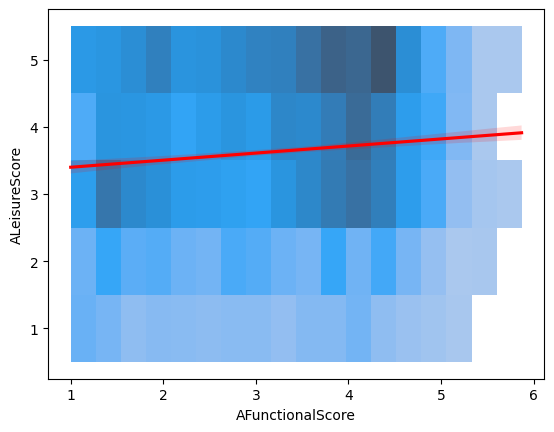

In [51]:
sns.histplot(df1, x='AFunctionalScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df1, x='AFunctionalScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

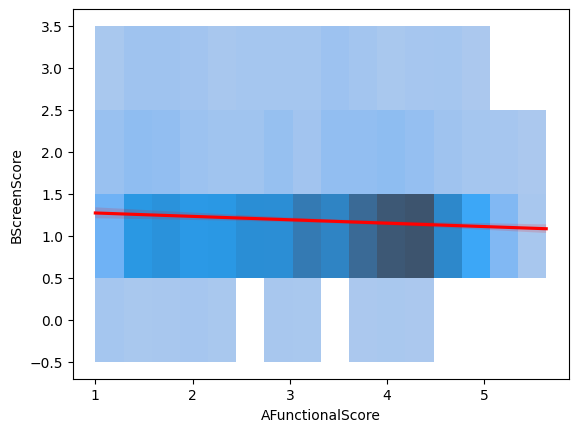

In [52]:
sns.histplot(df, x='AFunctionalScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

Let's also try with the alternative functional score.

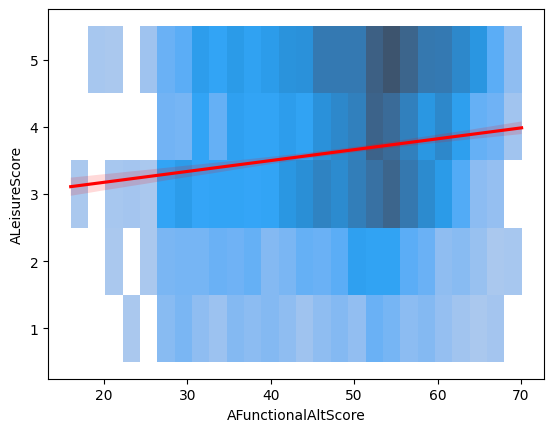

In [53]:
sns.histplot(df1, x='AFunctionalAltScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df1, x='AFunctionalAltScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

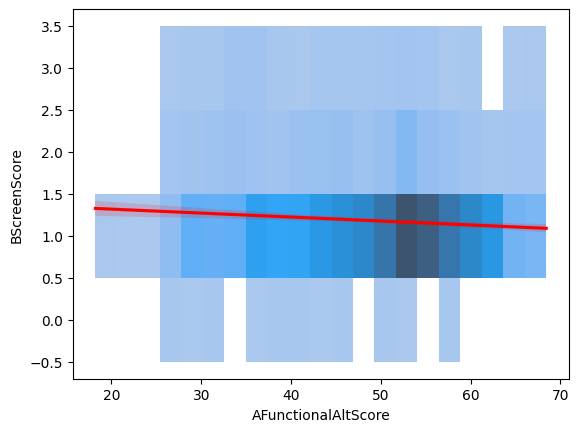

In [54]:
sns.histplot(df, x='AFunctionalAltScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

And the other alternative score.

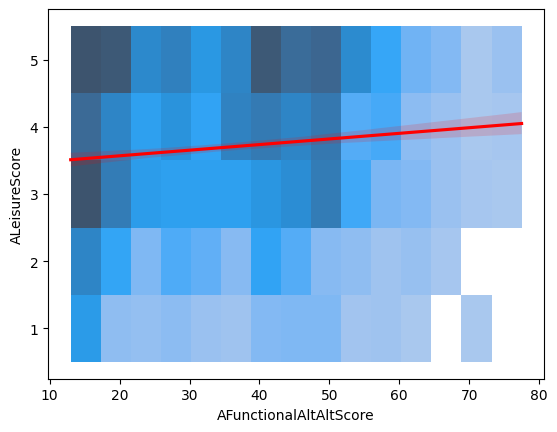

In [55]:
sns.histplot(df1, x='AFunctionalAltAltScore', y='ALeisureScore', discrete=(False, True))
sns.regplot(df1, x='AFunctionalAltAltScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

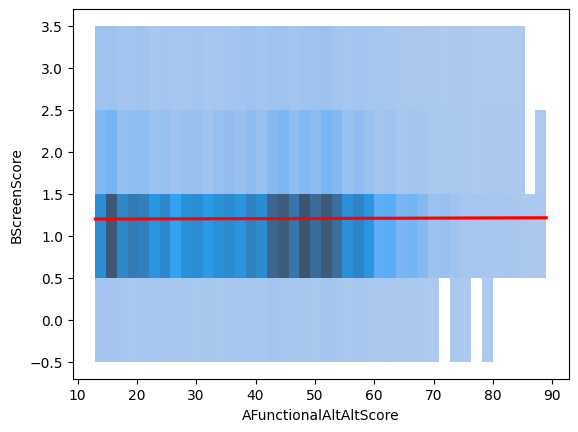

In [56]:
sns.histplot(df, x='AFunctionalAltAltScore', y='BScreenScore', discrete=(False, True))
sns.regplot(df, x='AFunctionalAltAltScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

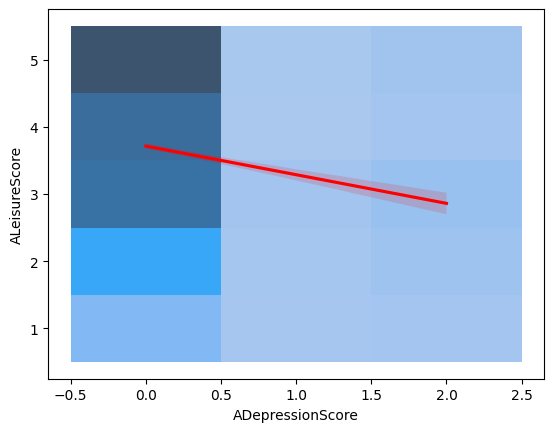

In [57]:
sns.histplot(df1, x='ADepressionScore', y='ALeisureScore', discrete=(True, True))
sns.regplot(df1, x='ADepressionScore', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

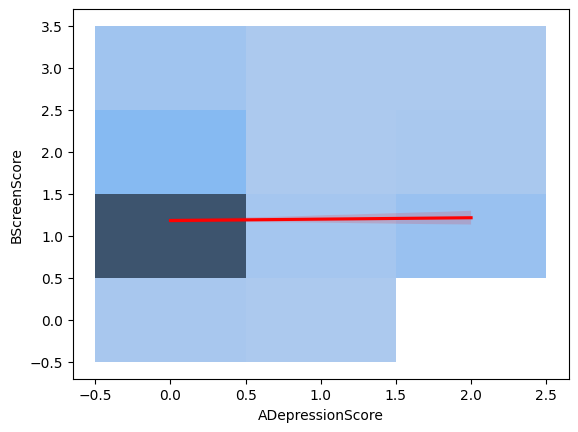

In [58]:
sns.histplot(df, x='ADepressionScore', y='BScreenScore', discrete=(True, True))
sns.regplot(df, x='ADepressionScore', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 3

> Are younger people more likely to engage in screen-based leisure?

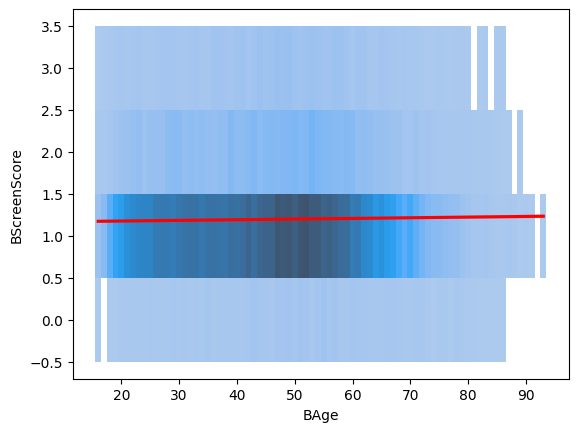

In [59]:
sub = df[df['BAge'].str.isnumeric()].copy()
sub['BAge'] = sub['BAge'].astype(int)
sns.histplot(sub, x='BAge', y='BScreenScore', discrete=(True, True))
sns.regplot(sub, x='BAge', y='BScreenScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

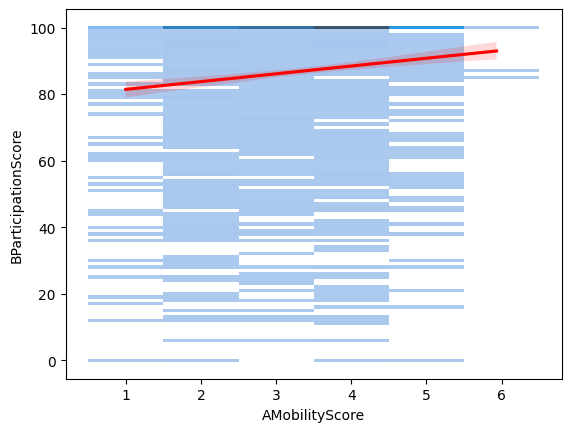

In [60]:
sns.histplot(df, x='AMobilityScore', y='BParticipationScore', discrete=(True, True))
sns.regplot(df, x='AMobilityScore', y='BParticipationScore', marker='', line_kws={'color':'r'})
plt.show()

### Question 5

> Is lower income associated with reduced leisure and higher depression?

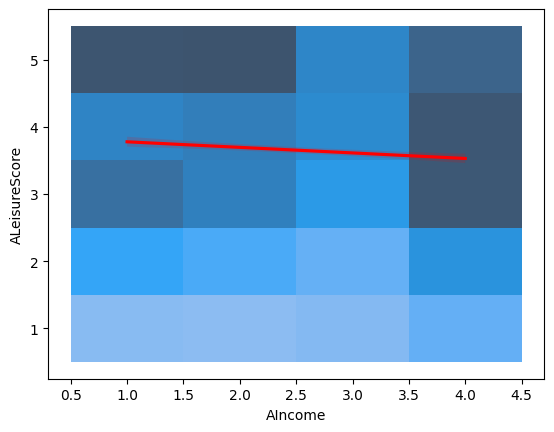

In [61]:
sns.histplot(df1, x='AIncome', y='ALeisureScore', discrete=(True, True))
sns.regplot(df1, x='AIncome', y='ALeisureScore', marker='', line_kws={'color':'r'})
plt.show()

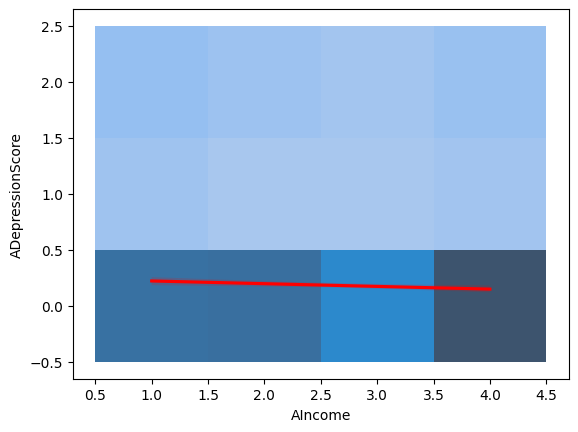

In [62]:
sns.histplot(df1, x='AIncome', y='ADepressionScore', discrete=(True, True))
sns.regplot(df1, x='AIncome', y='ADepressionScore', marker='', line_kws={'color':'r'})
plt.show()

### Bonus: Functionality over time

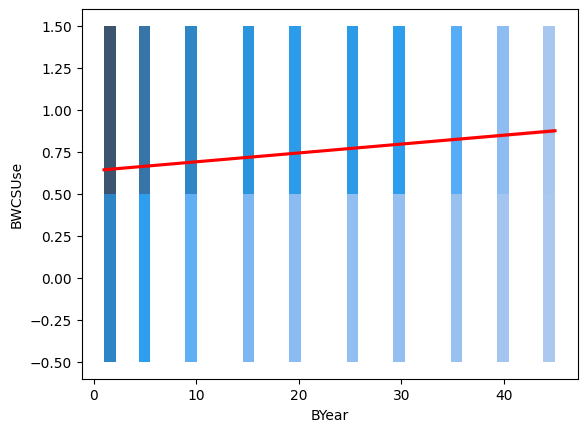

In [63]:
sns.histplot(df[df['BWCSUse'] <= 1], x='BYear', y='BWCSUse', discrete=(False, True))
sns.regplot(df[df['BWCSUse'] <= 1], x='BYear', y='BWCSUse', marker='', line_kws={'color':'r'})
plt.show()

Wheelchair/scooter use is actually increasing over time. This could mean that aging catches up faster than recovery.

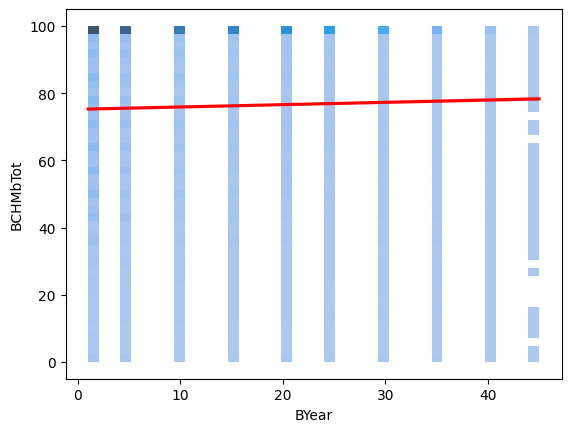

In [64]:
sns.histplot(df[df['BCHMbTot'] <= 100], x='BYear', y='BCHMbTot', discrete=(False, False))
sns.regplot(df[df['BCHMbTot'] <= 100], x='BYear', y='BCHMbTot', marker='', line_kws={'color':'r'})
plt.show()

Mobility (CHART-Mobility Total) increases slightly over time.

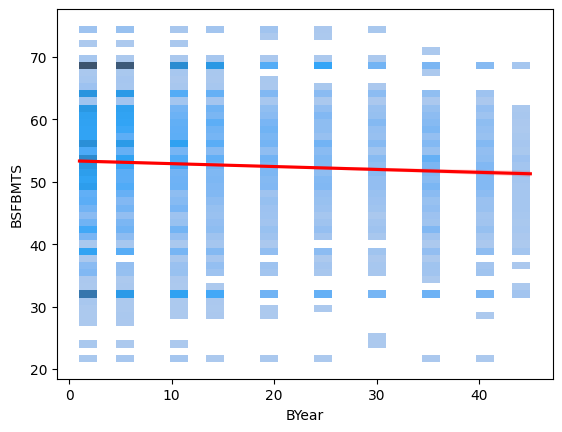

In [65]:
sns.histplot(df[df['BSFBMTS'] <= 100], x='BYear', y='BSFBMTS', discrete=(False, False))
sns.regplot(df[df['BSFBMTS'] <= 100], x='BYear', y='BSFBMTS', marker='', line_kws={'color':'r'})
plt.show()

But the Basic Mobility T-Score seems to be trending downward over time.

## Modeling

Let's now build both linear and non-linear models taking into account all the control variables.

In [66]:
from typing import List, Any, Dict

# Core model selection and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    r2_score,
    mean_squared_error,
    roc_curve,
    auc,
)

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model types
from sklearn.base import is_classifier, is_regressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


def train_and_evaluate_model(
    df: pd.DataFrame,
    target_col: str,
    categorical_cols: List[str],
    continuous_cols: List[str],
    model: Any,
) -> Dict[str, Any]:
    """
    Trains and evaluates a model using a full preprocessing pipeline.

    Args:
        df: The input pandas DataFrame.
        target_col: The name of the target variable column.
        categorical_cols: A list of column names for categorical features.
        continuous_cols: A list of column names for continuous features.
        model: An instantiated scikit-learn model (e.g., LogisticRegression()).

    Returns:
        A dictionary containing results needed for plotting, including:
        - 'model_type': 'classifier' or 'regressor'
        - 'y_test': The true values from the test set.
        - 'y_pred': The predicted values from the test set.
        - 'y_pred_proba': Predicted probabilities (for classifiers, else None).
        - 'model': The fitted pipeline object.
        - 'labels': Unique class labels (for classifiers, else None).
    """
    print(f"--- Starting model training for: {type(model).__name__} ---")

    # 1. Drop NAs for the target column
    df_clean = df.dropna(subset=[target_col])
    if len(df_clean) < len(df):
        print(f"Dropped {len(df) - len(df_clean)} rows with missing target.")

    # 2. Define features (X) and target (y)
    X = df_clean[categorical_cols + continuous_cols]
    y = df_clean[target_col]

    # 3. Detect model type
    model_type = None
    if is_classifier(model):
        model_type = "classifier"
    elif is_regressor(model):
        model_type = "regressor"
    else:
        raise ValueError("Model type (classifier/regressor) could not be determined.")

    print(f"Detected model type: {model_type}")

    # 4. Split the data (stratified for classifiers)
    stratify_param = y if model_type == "classifier" else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=stratify_param
    )

    # 5. Build preprocessing pipelines
    # Categorical pipeline: Impute missing as 'missing', then OneHotEncode
    categorical_pipeline = Pipeline(
        steps=[
            ("to_string", FunctionTransformer(lambda x: x.astype(str))),
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
        ]
    )

    # Continuous pipeline: Impute missing with median, then StandardScaler
    continuous_pipeline = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    # 6. Combine pipelines with ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat", categorical_pipeline, categorical_cols),
            ("cont", continuous_pipeline, continuous_cols),
        ],
        remainder="passthrough",  # Keep other columns if any (though we defined all)
    )

    # 7. Create the full pipeline
    full_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    for col in X_train.columns:
        # Get all unique types present in the column
        unique_types = X_train[col].apply(type).unique()
        
        # If there is more than one unique type, it's a mixed-type column
        if len(unique_types) > 1:
            print(f"**Mixed-Type Column Found:** '{col}'")
            print(f"  - Detected Types: {unique_types}")

    # 8. Train the model
    print("Fitting model pipeline...")
    full_pipeline.fit(X_train, y_train)

    # 9. Perform classification/regression
    y_pred = full_pipeline.predict(X_test)
    y_pred_proba = None
    labels = None

    # 10. Print summary and get plotting data
    if model_type == "classifier":
        labels = sorted(y.unique())
        print("\n--- Classification Report ---")
        print(classification_report(y_test, y_pred))
        if hasattr(full_pipeline, "predict_proba"):
            y_pred_proba = full_pipeline.predict_proba(X_test)

    elif model_type == "regressor":
        print("\n--- Regression Report ---")
        print(f"R-squared (R²): {r2_score(y_test, y_pred):.4f}")
        print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred):.4f}")
        print(
            f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}"
        )

    print(f"--- Model training complete for: {type(model).__name__} ---")

    # 11. Return necessary info for plotting
    return {
        "model_type": model_type,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba,
        "model": full_pipeline,
        "labels": labels,
    }


# --- Plotting Functions ---


def plot_confusion_matrix(
    y_test: pd.Series, y_pred: np.ndarray, labels: List[Any]
):
    """Plots a seaborn confusion matrix."""
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.title("Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()


def plot_roc_curve(y_test: pd.Series, y_pred_proba: np.ndarray, labels: List[Any]):
    """Plots the ROC curve for binary or multiclass classification."""
    if y_pred_proba is None:
        print("ROC curve not available (model does not support predict_proba).")
        return

    # Binary classification
    if len(labels) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], pos_label=labels[1])
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(
            fpr,
            tpr,
            color="darkorange",
            lw=2,
            label=f"ROC curve (area = {roc_auc:0.2f})",
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.show()
    else:
        # Multiclass: One-vs-Rest (OvR)
        # Binarize the output
        y_test_binarized = label_binarize(y_test, classes=labels)
        n_classes = len(labels)

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        print("Plotting One-vs-Rest (OvR) ROC curves for multiclass target.")
        plt.figure(figsize=(10, 8))

        # Plot all ROC curves
        for i, label in enumerate(labels):
            plt.plot(
                fpr[i],
                tpr[i],
                lw=2,
                label=f"ROC curve for class {label} (area = {roc_auc[i]:0.2f})",
            )

        plt.plot([0, 1], [0, 1], "k--", lw=2, label="No Skill")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Multiclass One-vs-Rest ROC")
        plt.legend(loc="lower right")
        plt.show()


def plot_residuals(y_test: pd.Series, y_pred: np.ndarray):
    """Plots a residual plot for regression models."""
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residual Plot")
    plt.show()


def plot_actual_vs_predicted(y_test: pd.Series, y_pred: np.ndarray):
    """Plots actual vs. predicted values for regression models."""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred, alpha=0.5)
    # Add a 45-degree line for reference
    lims = [
        min(min(y_test), min(y_pred)),
        max(max(y_test), max(y_pred)),
    ]
    plt.plot(lims, lims, "r--", alpha=0.75, label="Perfect Prediction")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted")
    plt.legend()
    plt.axis("square")
    plt.show()


def run_plots(plot_data: Dict[str, Any]):
    """
    Runs the appropriate plots based on model type.

    Args:
        plot_data: The dictionary returned by train_and_evaluate_model.
    """
    model_type = plot_data["model_type"]
    y_test = plot_data["y_test"]
    y_pred = plot_data["y_pred"]

    if model_type == "classifier":
        labels = plot_data["labels"]
        y_pred_proba = plot_data["y_pred_proba"]
        plot_confusion_matrix(y_test, y_pred, labels)
        plot_roc_curve(y_test, y_pred_proba, labels)
    elif model_type == "regressor":
        plot_residuals(y_test, y_pred)
        plot_actual_vs_predicted(y_test, y_pred)

### Question 1

> Do people with high functional scores still report low engagement in leisure or screen-based activities?

We'll fit a logistic regression model for `ALeisureScore` using `AFunctionalScore` and the control variables defined above, then visualise the relationship and the model coefficients.

--- Starting model training for: LogisticRegression ---
Dropped 128898 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         1.0       0.14      0.07      0.10        28
         2.0       0.15      0.14      0.15        56
         3.0       0.32      0.30      0.31       113
         4.0       0.35      0.36      0.35       117
         5.0       0.45      0.51      0.48       150

    accuracy                           0.35       464
   macro avg       0.28      0.28      0.28       464
weighted avg       0.34      0.35      0.34       464

--- Model training complete for: LogisticRegression ---


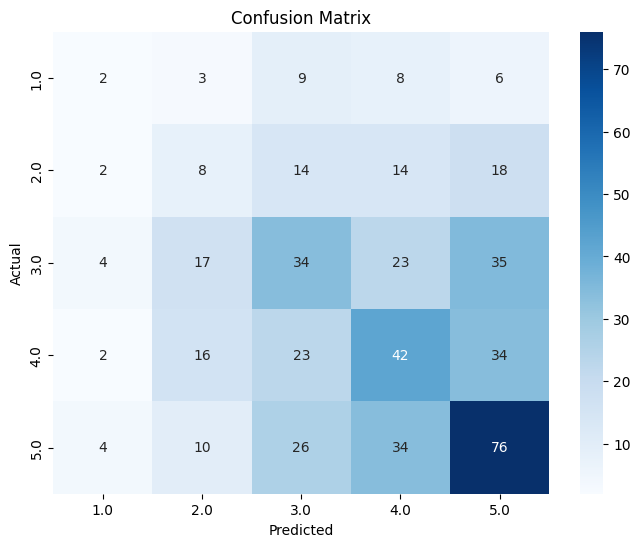

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


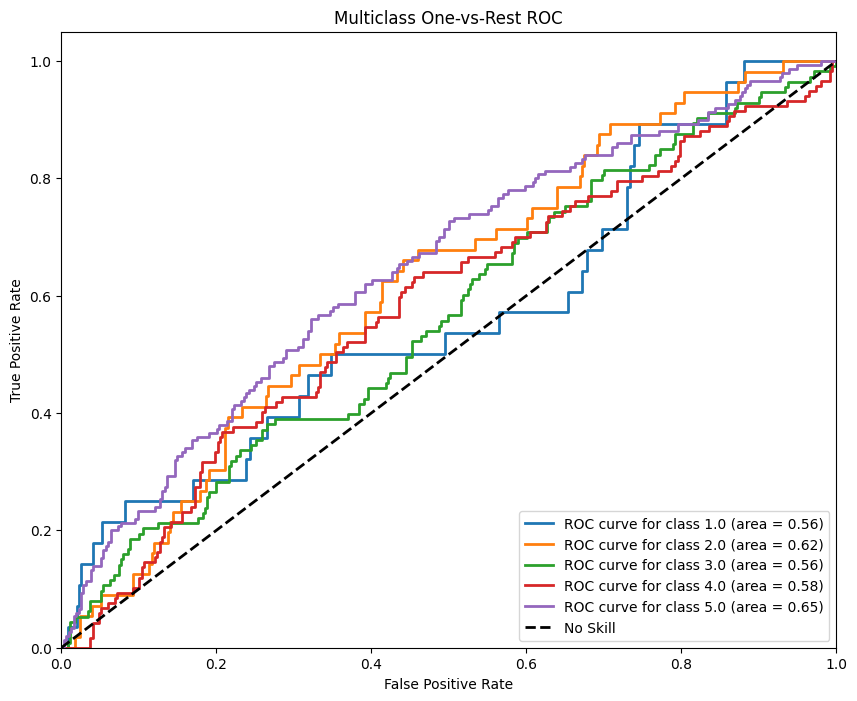

In [67]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df,
    'ALeisureScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: LogisticRegression ---
Dropped 101293 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.10      0.01      0.02       163
         1.0       0.80      0.99      0.89      4769
         2.0       0.39      0.04      0.07       769
         3.0       0.15      0.01      0.02       284

    accuracy                           0.80      5985
   macro avg       0.36      0.26      0.25      5985
weighted avg       0.70      0.80      0.72      5985

--- Model training complete for: LogisticRegression ---


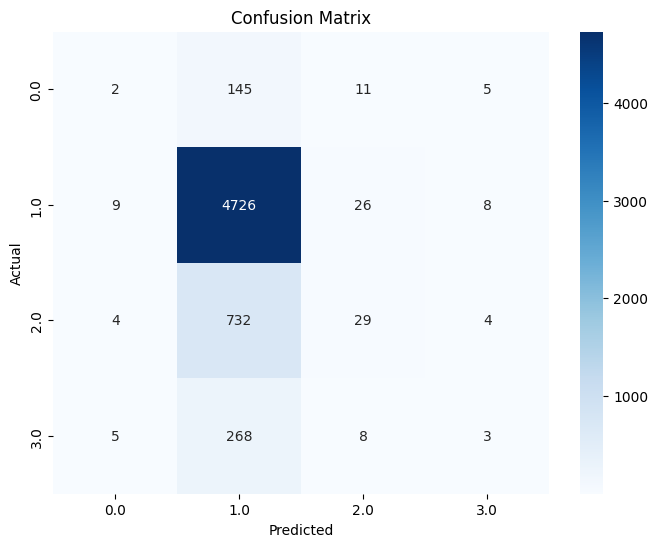

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


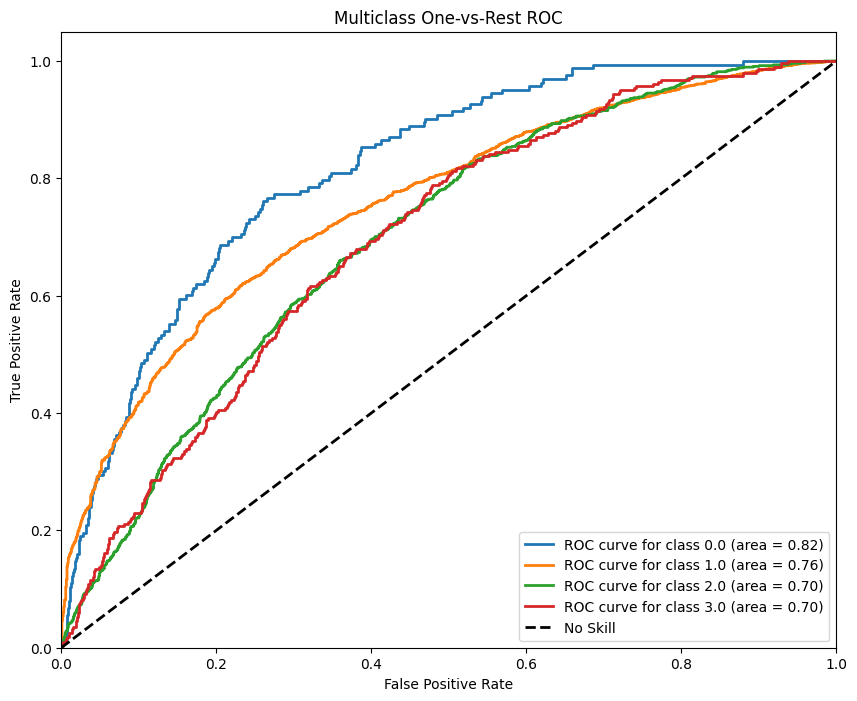

In [68]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: LogisticRegression ---
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.76      0.69      0.73      2166
         1.0       0.88      0.91      0.89      5250

    accuracy                           0.85      7416
   macro avg       0.82      0.80      0.81      7416
weighted avg       0.84      0.85      0.84      7416

--- Model training complete for: LogisticRegression ---


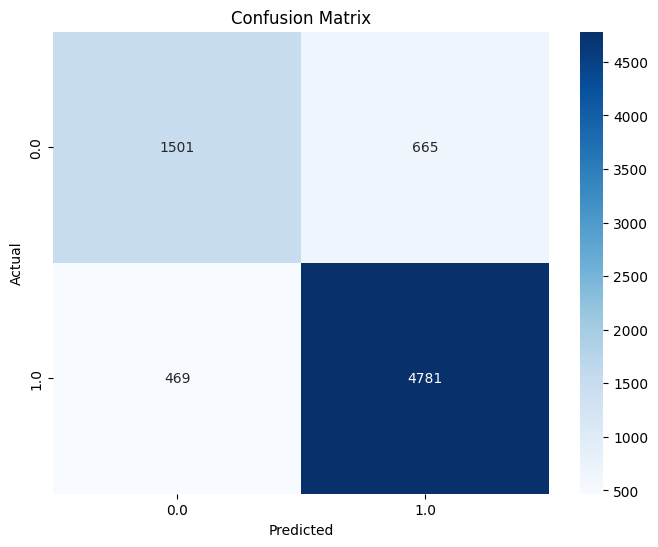

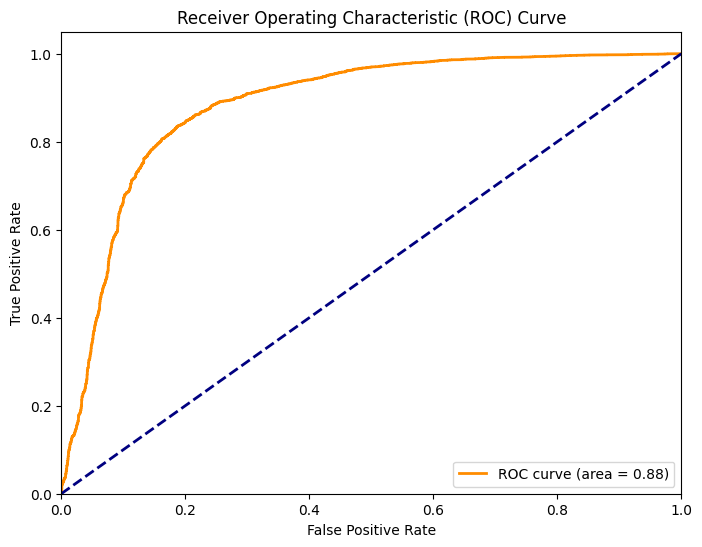

In [69]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df[df['BWCSUse'] < 9],
    'BWCSUse',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

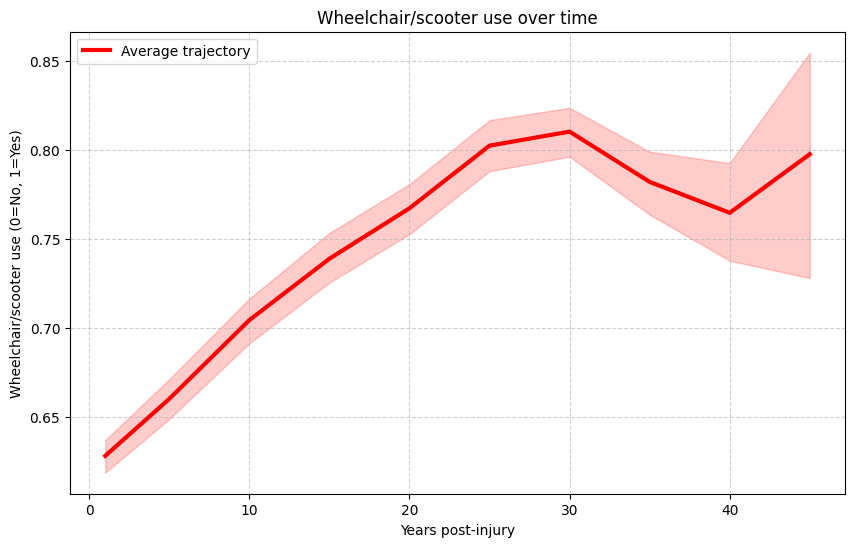

In [70]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df[df['BWCSUse'] < 2],
    x='BYear',
    y='BWCSUse',
    color='red',
    linewidth=3,
    label='Average trajectory'
)

plt.title('Wheelchair/scooter use over time')
plt.xlabel('Years post-injury')
plt.ylabel('Wheelchair/scooter use (0=No, 1=Yes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

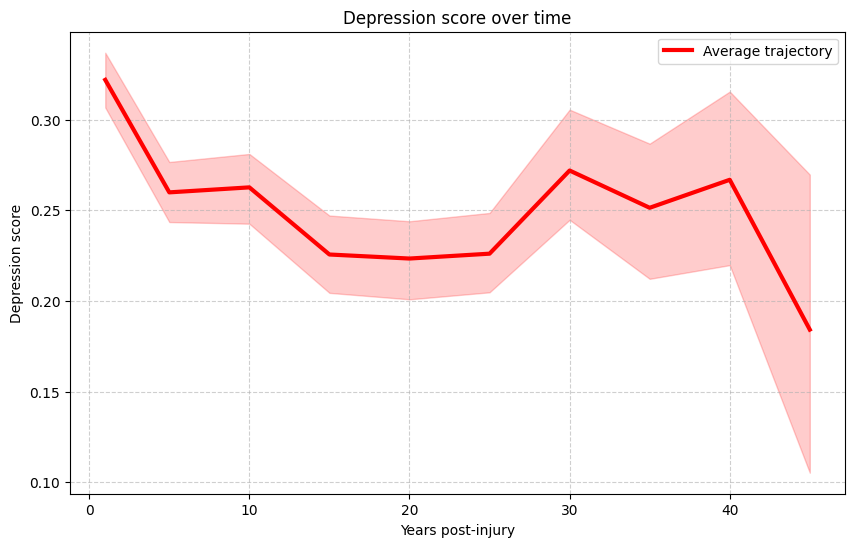

In [71]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df[df['BBPHQMDS'] < 3],
    x='BYear',
    y='BBPHQMDS',
    color='red',
    linewidth=3,
    label='Average trajectory'
)

plt.title('Depression score over time')
plt.xlabel('Years post-injury')
plt.ylabel('Depression score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Let's see how results compare to a Random Forest classifier.

--- Starting model training for: RandomForestClassifier ---
Dropped 128898 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         1.0       1.00      0.04      0.07        28
         2.0       0.33      0.02      0.03        56
         3.0       0.28      0.25      0.26       113
         4.0       0.25      0.22      0.23       117
         5.0       0.39      0.67      0.49       150

    accuracy                           0.34       464
   macro avg       0.45      0.24      0.22       464
weighted avg       0.36      0.34      0.29       464

--- Model training complete for: RandomForestClassifier ---


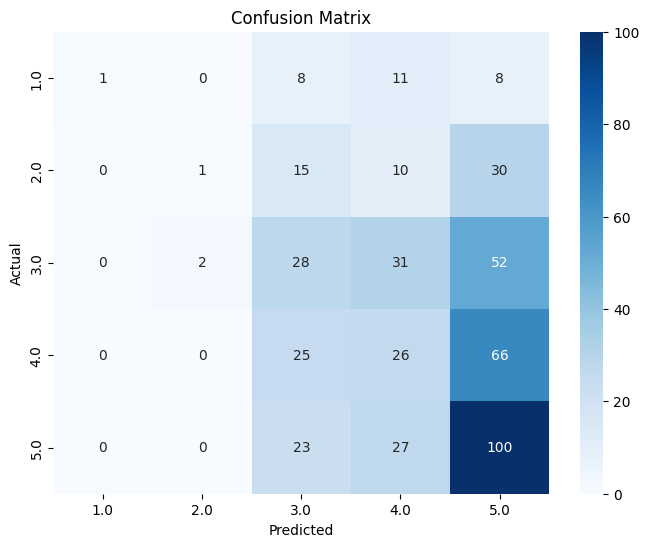

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


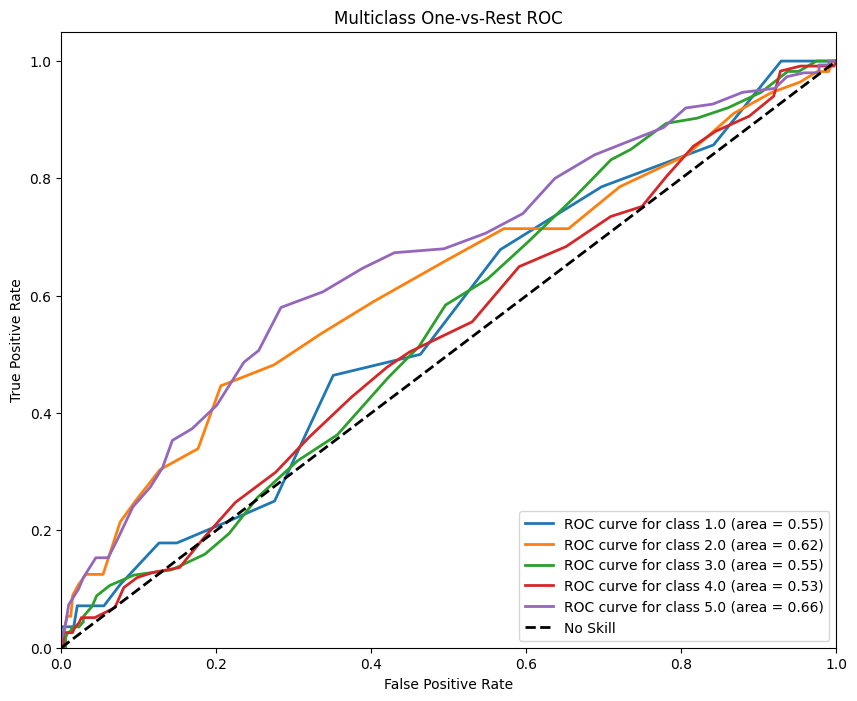

In [72]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
     df,
    'ALeisureScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

--- Starting model training for: RandomForestClassifier ---
Dropped 101293 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.33      0.01      0.01       163
         1.0       0.80      1.00      0.89      4769
         2.0       0.33      0.01      0.01       769
         3.0       0.00      0.00      0.00       284

    accuracy                           0.80      5985
   macro avg       0.37      0.25      0.23      5985
weighted avg       0.69      0.80      0.71      5985

--- Model training complete for: RandomForestClassifier ---


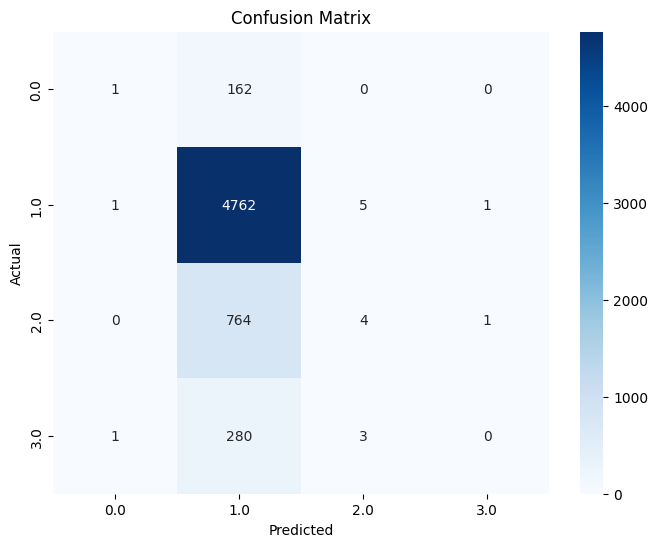

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


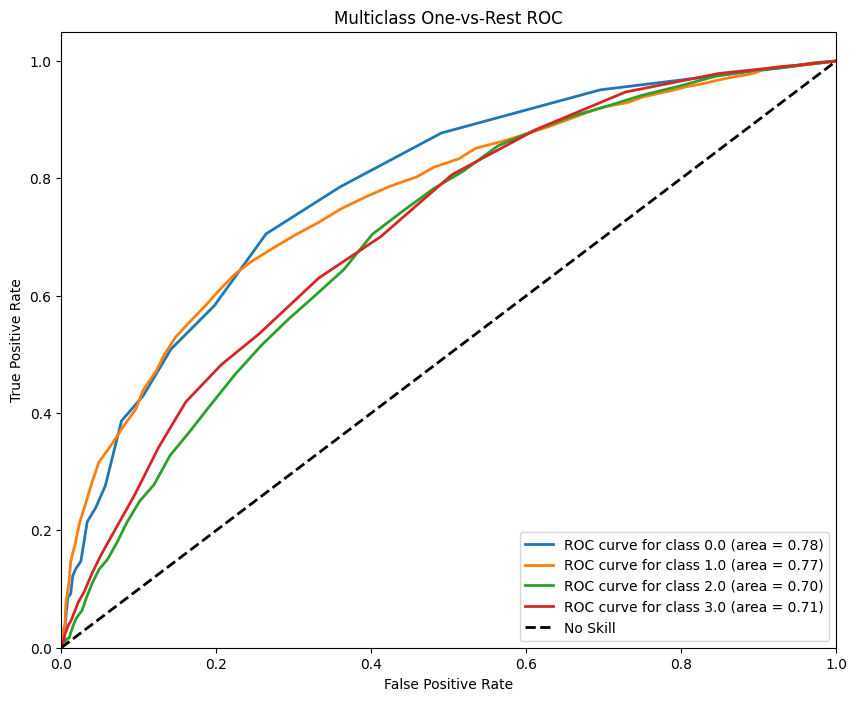

In [73]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
     df,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

### Question 2

> Do higher depression scores correlate with lower leisure/screen engagement?

_Depression score was already included above._

### Question 3

> Are younger people more likely to engage in screen-based leisure?

In [74]:
sub = df[df['BAge'].str.isnumeric()].copy()
sub['BAge'] = sub['BAge'].astype(int)

--- Starting model training for: LogisticRegression ---
Dropped 98607 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.31      0.03      0.06       160
         1.0       0.80      0.99      0.89      4672
         2.0       0.29      0.03      0.05       756
         3.0       0.47      0.03      0.05       281

    accuracy                           0.80      5869
   macro avg       0.47      0.27      0.26      5869
weighted avg       0.71      0.80      0.72      5869

--- Model training complete for: LogisticRegression ---


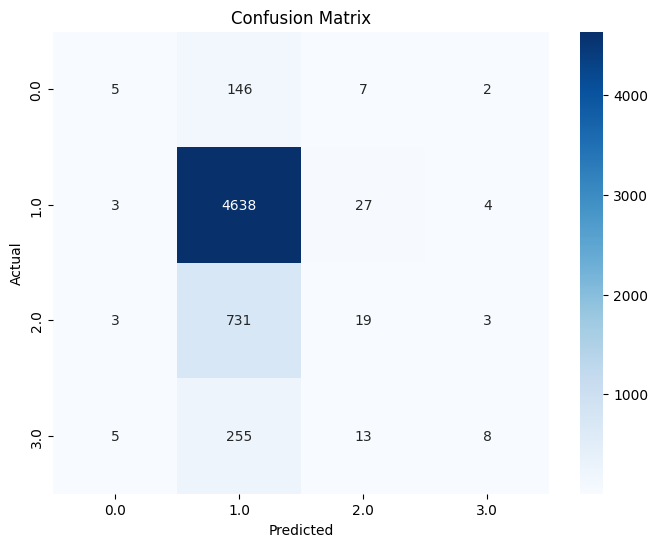

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


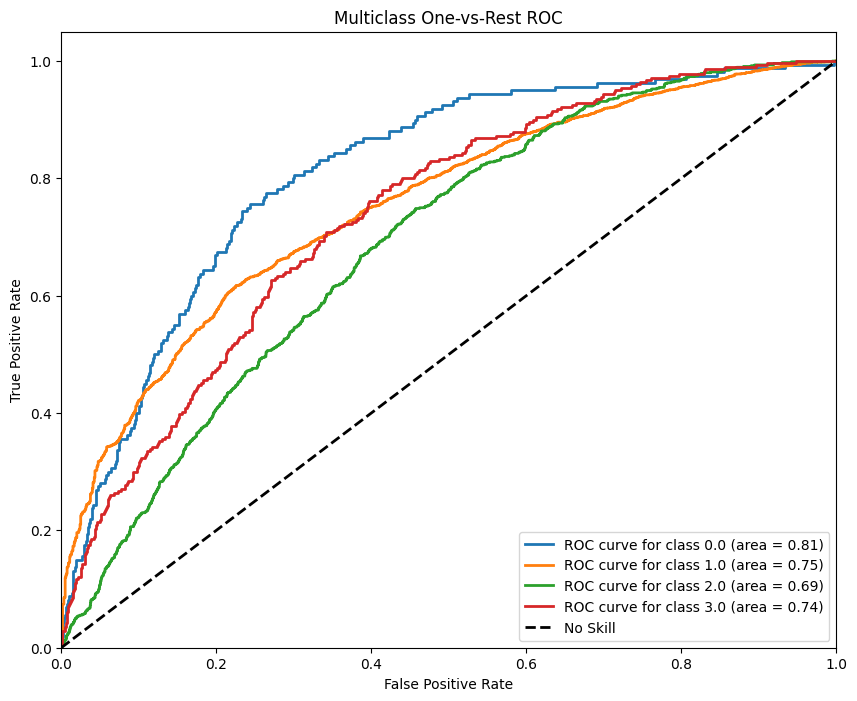

In [75]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    sub,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: RandomForestClassifier ---
Dropped 98607 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       160
         1.0       0.80      1.00      0.89      4672
         2.0       0.24      0.01      0.01       756
         3.0       0.00      0.00      0.00       281

    accuracy                           0.80      5869
   macro avg       0.26      0.25      0.22      5869
weighted avg       0.67      0.80      0.71      5869

--- Model training complete for: RandomForestClassifier ---


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

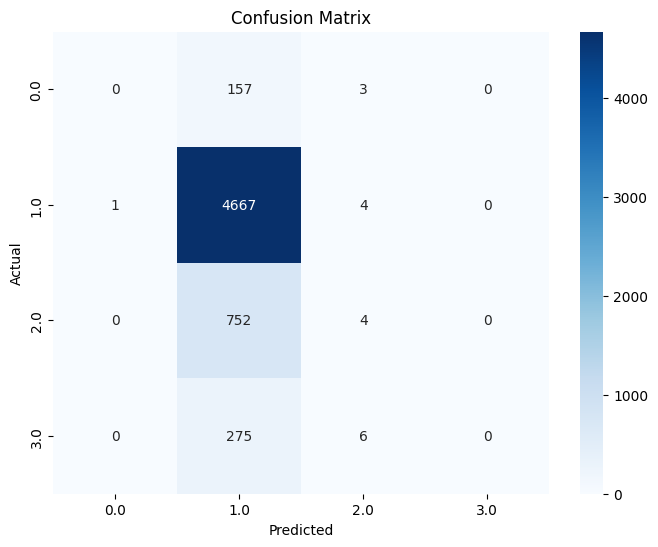

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


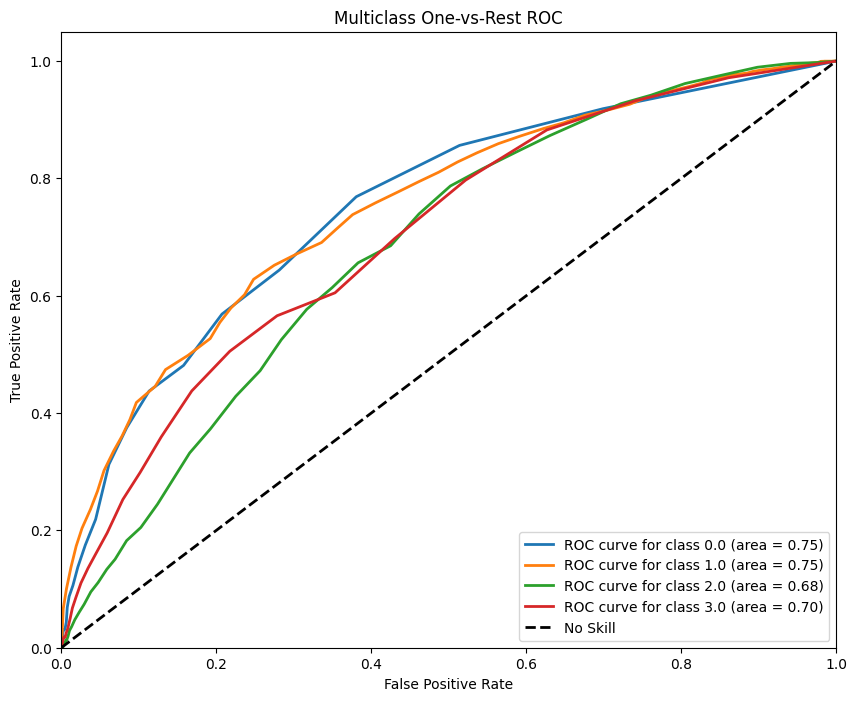

In [76]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
    sub,
    'BScreenScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

### Question 4

> Do mobility users report lower participation?

Note: not sure if _mobility user_ means something specific or if the question is just missing a word (_low_).

--- Starting model training for: LinearRegression ---
Dropped 84841 rows with missing target.
Detected model type: regressor
Fitting model pipeline...

--- Regression Report ---
R-squared (R²): 0.2331
Mean Squared Error (MSE): 412.7486
Root Mean Squared Error (RMSE): 20.3162
--- Model training complete for: LinearRegression ---


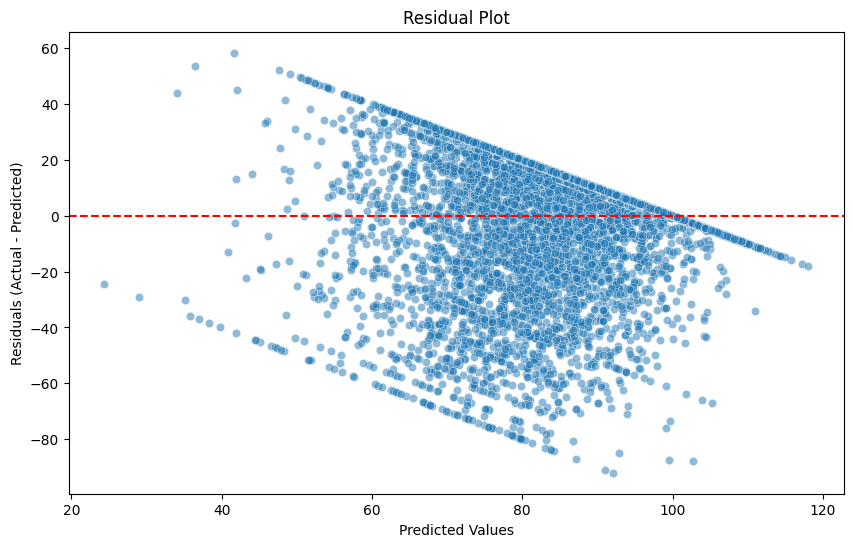

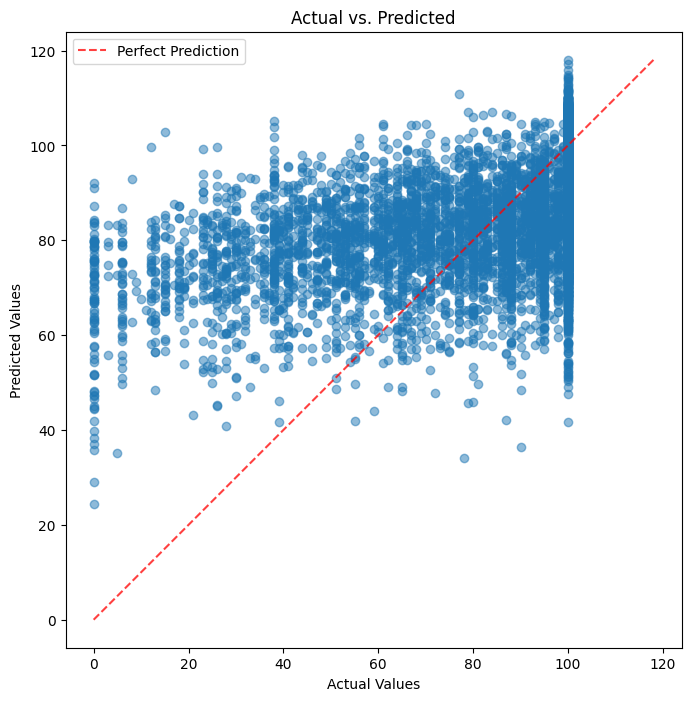

In [77]:
lin_reg = LinearRegression()

plot_data_lin = train_and_evaluate_model(
    df,
    'BParticipationScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    lin_reg,
)
run_plots(plot_data_lin)

--- Starting model training for: RandomForestRegressor ---
Dropped 84841 rows with missing target.
Detected model type: regressor
Fitting model pipeline...

--- Regression Report ---
R-squared (R²): 0.2928
Mean Squared Error (MSE): 380.6198
Root Mean Squared Error (RMSE): 19.5095
--- Model training complete for: RandomForestRegressor ---


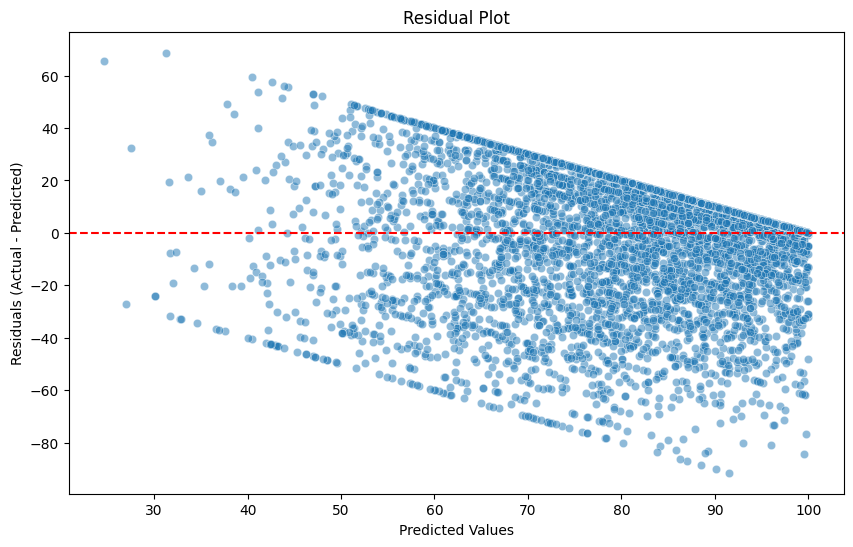

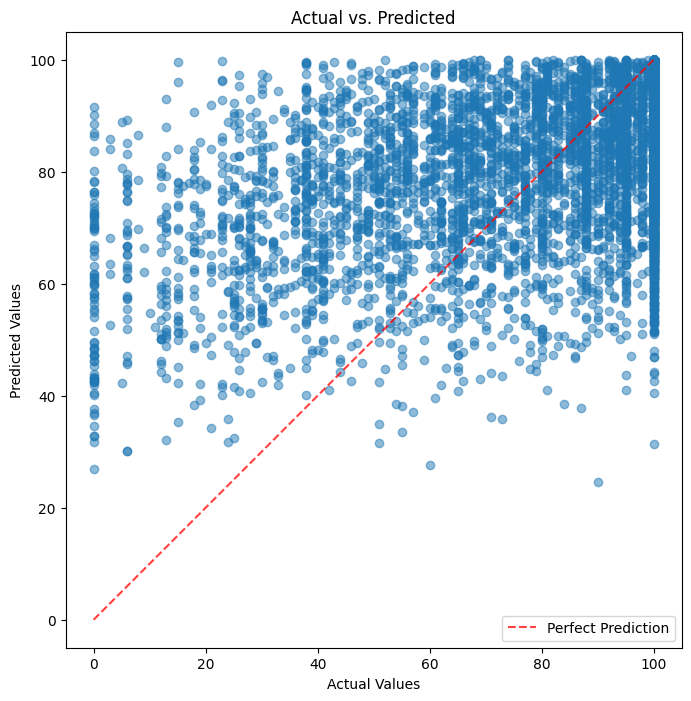

In [78]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

plot_data_rf_reg = train_and_evaluate_model(
    df,
    'BParticipationScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_reg
)

run_plots(plot_data_rf_reg)

### Question 5

> Is lower income associated with reduced leisure and higher depression?

_Leisure, see above._

--- Starting model training for: LogisticRegression ---
Dropped 128928 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       410
         1.0       0.14      0.06      0.09        16
         2.0       0.14      0.03      0.05        32

    accuracy                           0.88       458
   macro avg       0.40      0.36      0.36       458
weighted avg       0.83      0.88      0.85       458

--- Model training complete for: LogisticRegression ---


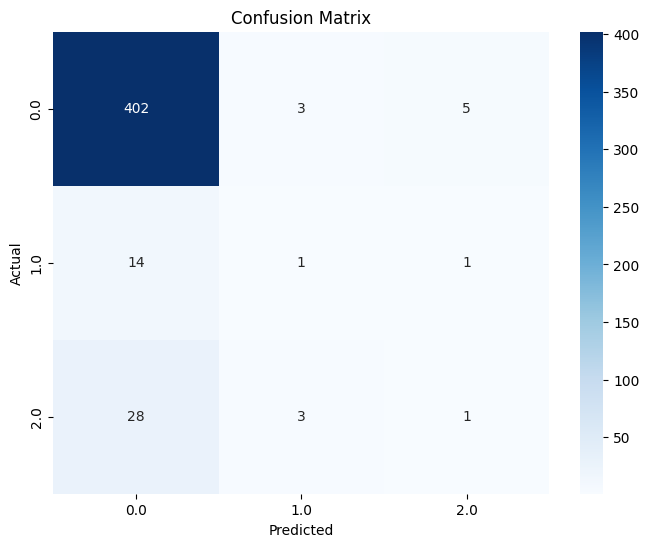

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


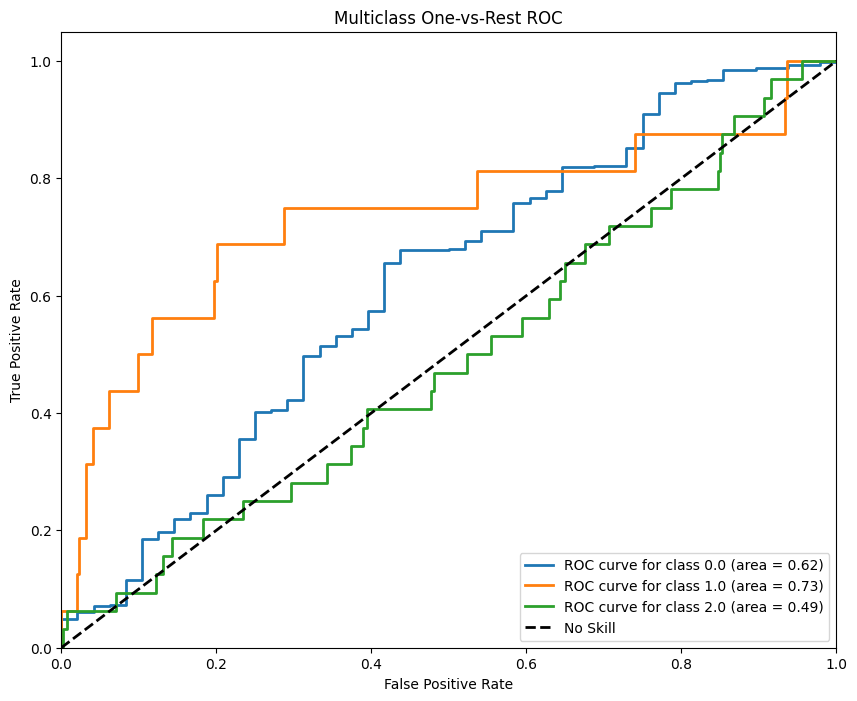

In [79]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)

plot_data_log = train_and_evaluate_model(
    df,
    'ADepressionScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ALeisureScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    log_reg,
)

run_plots(plot_data_log)

--- Starting model training for: RandomForestClassifier ---
Dropped 128928 rows with missing target.
Detected model type: classifier
Fitting model pipeline...

--- Classification Report ---
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94       410
         1.0       0.00      0.00      0.00        16
         2.0       0.00      0.00      0.00        32

    accuracy                           0.90       458
   macro avg       0.30      0.33      0.31       458
weighted avg       0.80      0.90      0.85       458

--- Model training complete for: RandomForestClassifier ---


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

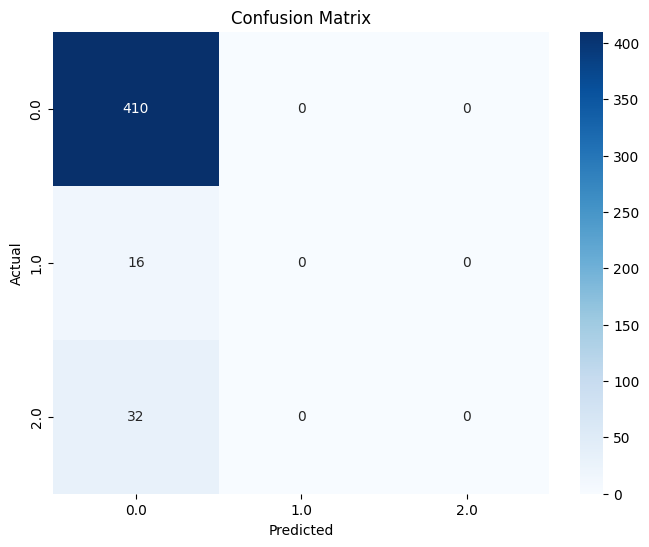

Plotting One-vs-Rest (OvR) ROC curves for multiclass target.


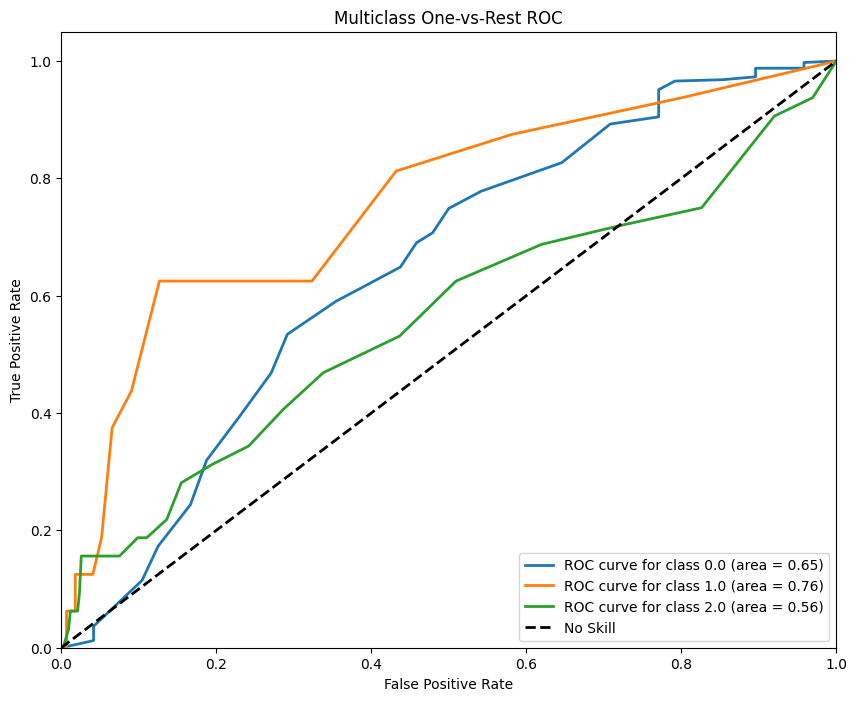

In [80]:
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)

plot_data_rf = train_and_evaluate_model(
     df,
    'ADepressionScore',
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ALeisureScore',
        # 'BAge',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    rf_class,
)

run_plots(plot_data_rf)

## Mixed-effect models

In [81]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

cov_struct = sm.cov_struct.Exchangeable()

model = smf.gee(
    "BWCSUse ~ BYear",
    groups="UniID",
    data=df[df['BWCSUse'] < 2],
    cov_struct=cov_struct,
    family=sm.families.Binomial()
)

result = model.fit()
print(result.summary())

                               GEE Regression Results                              
Dep. Variable:                     BWCSUse   No. Observations:                37078
Model:                                 GEE   No. clusters:                    18729
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   5
Family:                           Binomial   Mean cluster size:                 2.0
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Mon, 22 Dec 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         23:54:09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6198      0.019     32.420      0.000       0.582       0.657
BYear  

/Users/imene/src/spinal/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


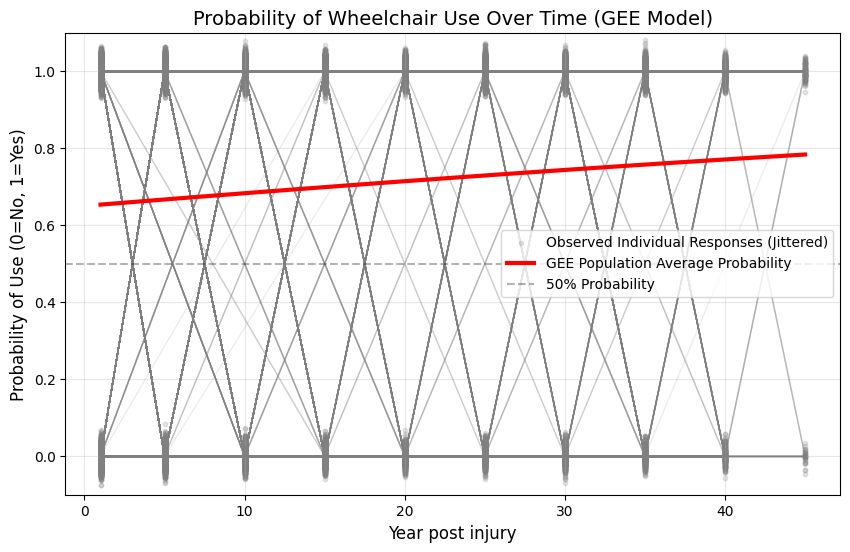

In [82]:
time_min = df[df['BWCSUse'] < 2]['BYear'].min()
time_max = df[df['BWCSUse'] < 2]['BYear'].max()

pred_data = pd.DataFrame({
    'BYear': np.linspace(time_min, time_max, 100)
})

pred_data['Predicted_Prob'] = result.predict(pred_data)

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df[df['BWCSUse'] < 2],
    x='BYear',
    y='BWCSUse',
    units='UniID',  # Treat each UniID as a separate unit (line)
    estimator=None,     # Do not aggregate the lines (use raw data points)
    color='gray',
    alpha=0.15,
    linewidth=1,
    ax=plt.gca(),       # Use the current Matplotlib axes
    legend=False        # Suppress automatic legend entry
)

jitter_y = df[df['BWCSUse'] < 2]['BWCSUse'] + np.random.normal(0, 0.02, size=len(df[df['BWCSUse'] < 2]))

plt.scatter(
    df[df['BWCSUse'] < 2]['BYear'], 
    jitter_y, 
    alpha=0.2,       # High transparency to handle overlapping points
    color='gray', 
    label='Observed Individual Responses (Jittered)',
    s=10
)

# B. Plot the GEE Prediction Line
plt.plot(
    pred_data['BYear'], 
    pred_data['Predicted_Prob'], 
    color='red', 
    linewidth=3, 
    label='GEE Population Average Probability'
)

# --- 4. Formatting ---
plt.title('Probability of Wheelchair Use Over Time (GEE Model)', fontsize=14)
plt.xlabel('Year post injury', fontsize=12)
plt.ylabel('Probability of Use (0=No, 1=Yes)', fontsize=12)
plt.ylim(-0.1, 1.1) # Set limits slightly beyond 0-1 for clarity
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3, label='50% Probability')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [83]:
model_linear = smf.gee(
    "BBPHQMDS ~ BYear",
    groups="UniID",
    data=df[df['BBPHQMDS'] < 3],
    cov_struct=sm.cov_struct.Exchangeable(), # Accounts for repeated measures correlation
    family=sm.families.Gaussian()          # The "Linear Regression" family
)

result_linear = model_linear.fit()
print(result_linear.summary())

                               GEE Regression Results                              
Dep. Variable:                    BBPHQMDS   No. Observations:                28033
Model:                                 GEE   No. clusters:                    17257
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   5
Family:                           Gaussian   Mean cluster size:                 1.6
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Mon, 22 Dec 2025   Scale:                           0.376
Covariance type:                    robust   Time:                         23:54:20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2940      0.006     50.042      0.000       0.282       0.306
BYear  

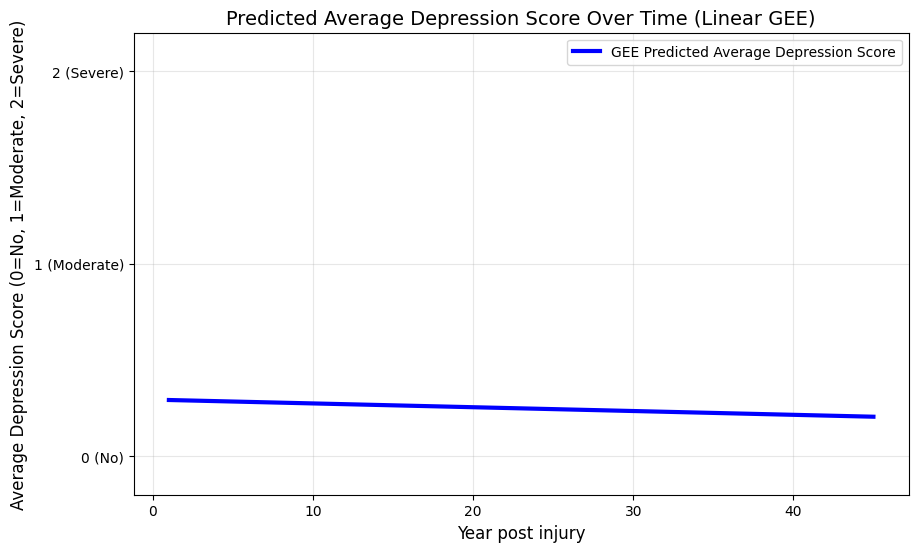

In [84]:
time_min = df[df['BBPHQMDS'] < 3]['BYear'].min()
time_max = df[df['BBPHQMDS'] < 3]['BYear'].max()
pred_df = pd.DataFrame({'BYear': np.linspace(time_min, time_max, 100)})
pred_df['Predicted_Score'] = result_linear.predict(pred_df)

plt.figure(figsize=(10, 6))

plt.plot(
    pred_df['BYear'],
    pred_df['Predicted_Score'],
    color='blue',
    linewidth=3,
    label='GEE Predicted Average Depression Score'
)

plt.title('Predicted Average Depression Score Over Time (Linear GEE)', fontsize=14)
plt.xlabel('Year post injury', fontsize=12)
plt.ylabel('Average Depression Score (0=No, 1=Moderate, 2=Severe)', fontsize=12)
plt.yticks([0, 1, 2], ['0 (No)', '1 (Moderate)', '2 (Severe)']) # Label the discrete values
plt.ylim(-0.2, 2.2)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [85]:
from statsmodels.genmod.generalized_estimating_equations import OrdinalGEE

model_ordinal = OrdinalGEE.from_formula(
    "BBPHQMDS ~ BYear",
    groups="UniID",
    data=df[df['BBPHQMDS'] < 3],
    constraint=None  # Default is proportional odds
)

result_ordinal = model_ordinal.fit()
print(result_ordinal.summary())

/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1300: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1300: IterationLimitWarning: Iteration limit reached prior to convergence
  warnings.warn("Iteration limit reached prior to convergence",


                           OrdinalGEE Regression Results                           
Dep. Variable:                           y   No. Observations:                56066
Model:                          OrdinalGEE   No. clusters:                    17257
Method:                        Generalized   Min. cluster size:                   2
                      Estimating Equations   Max. cluster size:                  10
Family:                           Binomial   Mean cluster size:                 3.2
Dependence structure:  OrdinalIndependence   Num. iterations:                    60
Date:                     Mon, 22 Dec 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         23:54:54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
I(y>0.0)   -2.046e+11   6.96e+04  -2.94e+06      0.000   -2.05e+11   -2.05e+11
I(y>1.0

Now let's formalize the mixed-effects models.

In [86]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.cov_struct import Exchangeable, Independence 
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from typing import List, Any, Dict

def train_mixed_effects_model(
    df: pd.DataFrame,
    target_col: str,
    random_effect_col: str,
    categorical_cols: List[str],
    continuous_cols: List[str],
    model_type: str = "auto",
) -> Dict[str, Any]:
    
    print(f"--- Starting Training (Group: {random_effect_col}) ---")

    # 1. Clean Data
    df_clean = df.dropna(subset=[target_col, random_effect_col]).copy()
    
    # 2. Determine Model Type
    model_type = model_type.lower().strip()
    if model_type == 'auto':
        if pd.api.types.is_numeric_dtype(df_clean[target_col]) and \
           set(df_clean[target_col].dropna().unique()).issubset({0, 1}):
            standardized_type = 'classifier'
        else:
            standardized_type = 'regressor'
    elif model_type in ['classification', 'classifier', 'logistic']:
        standardized_type = 'classifier'
    else:
        standardized_type = 'regressor'

    labels = None
    if standardized_type == "classifier":
        if not pd.api.types.is_numeric_dtype(df_clean[target_col]):
            print(f"Encoding target '{target_col}'...")
            original_categories = df_clean[target_col].astype('category').cat.categories
            labels = list(original_categories) 
            df_clean[target_col] = df_clean[target_col].astype('category').cat.codes
        else:
            labels = [0, 1]

    print(f"Model Intent: {standardized_type}")

    # 3. Preprocessing Pipeline
    categorical_pipeline = Pipeline([
        ('to_string', FunctionTransformer(lambda x: x.astype(str), validate=False)),
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')) 
    ])

    continuous_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ('cat', categorical_pipeline, categorical_cols),
        ('cont', continuous_pipeline, continuous_cols)
    ])

    # 4. Split Data
    stratify = df_clean[target_col] if standardized_type == 'classifier' else None
    train_idx, test_idx = train_test_split(
        df_clean.index, test_size=0.2, random_state=42, stratify=stratify
    )
    
    df_train = df_clean.loc[train_idx]
    df_test = df_clean.loc[test_idx]

    # 5. Fit & Transform Features
    print("Preprocessing features...")
    X_train_processed_raw = preprocessor.fit_transform(df_train[categorical_cols + continuous_cols])
    X_test_processed_raw = preprocessor.transform(df_test[categorical_cols + continuous_cols])

    # 6. Prepare Statsmodels Data
    endog_train = df_train[target_col].values
    groups_train = df_train[random_effect_col].values
    exog_train = sm.add_constant(X_train_processed_raw, prepend=True)
    exog_test = sm.add_constant(X_test_processed_raw, prepend=True)
    y_test = df_test[target_col].values

    # CHECK CLUSTER SIZES
    cluster_counts = df_train[random_effect_col].value_counts()
    mean_cluster_size = cluster_counts.mean()
    
    use_simple_model = (mean_cluster_size < 1.1)
    if use_simple_model:
        print("WARNING: Data is effectively cross-sectional (1 row per patient).")
        print("Falling back to standard GLM/OLS to avoid numeric instability.")

    fitted_model = None
    y_pred = None
    y_pred_proba = None

    try:
        if standardized_type == "regressor":
            if use_simple_model:
                print("Fitting Standard OLS (Regression)...")
                model_sm = sm.OLS(endog_train, exog_train)
                fitted_model = model_sm.fit()
            else:
                print("Fitting Linear Mixed Effects Model (MixedLM)...")
                model_sm = sm.MixedLM(endog_train, exog_train, groups=groups_train)
                fitted_model = model_sm.fit()
            
            print(fitted_model.summary())
            y_pred = fitted_model.predict(exog_test)

        elif standardized_type == "classifier":
            family = sm.families.Binomial()
            
            if use_simple_model:
                print("Fitting Standard GLM (Logistic Regression)...")
                # print("Fitting Standard GLM (Logistic Regression) with L2 Penalty (Ridge)...")
                model_sm = sm.GLM(endog_train, exog_train, family=family)
                fitted_model = model_sm.fit()
                # # alpha=0.01 adds a small penalty to keep coefficients from exploding
                # fitted_model = model_sm.fit_regularized(alpha=0.01, L1_wt=0)
            else:
                print("Fitting GEE (Generalized Estimating Equations)...")
                cov_struct = Independence() 
                model_sm = sm.GEE(endog_train, exog_train, groups=groups_train, family=family, cov_struct=cov_struct)
                fitted_model = model_sm.fit()
            
            print(fitted_model.summary())
            
            raw_probs = fitted_model.predict(exog_test)
            y_pred_proba = np.column_stack((1 - raw_probs, raw_probs))
            
            y_pred = (raw_probs > 0.5).astype(int)

    except Exception as e:
        print(f"\nCRITICAL FAILURE: {e}")
        raise e

    # 8. Evaluation
    print("\n--- Evaluation ---")
    if standardized_type == "regressor":
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"R2: {r2:.4f}, RMSE: {rmse:.4f}")
    else:
        print(classification_report(y_test, y_pred, labels=labels if labels and isinstance(labels[0], int) else None))

    return {
        "model_type": standardized_type,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_pred_proba": y_pred_proba, 
        "model": fitted_model,
        "labels": labels,
        "preprocessor": preprocessor
    }

--- Diagnostic Report ---

Top Correlations with Target:
ALeisureScore    1.000000
BCHOpTot         0.017733
BCHMbTot         0.011781
BCHPITot         0.007226
BPainSev        -0.004079
BRhspDaT        -0.019977
BRhspNbr        -0.032582
Name: ALeisureScore, dtype: float64


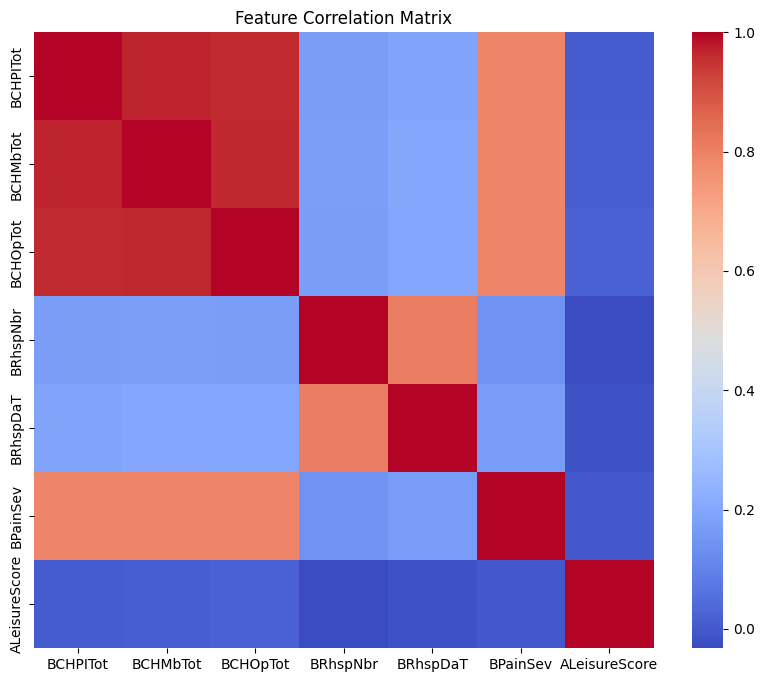


Categorical Column Check (Looking for 'Thin' categories):
- 'APResInj' has 1 categories with fewer than 5 observations.
- 'BSACoc' has 1 categories with fewer than 5 observations.
- 'ASAInhl' has 2 categories with fewer than 5 observations.
- 'BSAInhl' has 2 categories with fewer than 5 observations.
- 'ASASed' has 1 categories with fewer than 5 observations.
- 'ASAHall' has 2 categories with fewer than 5 observations.
- 'BSAHall' has 1 categories with fewer than 5 observations.
- 'ASAOthr' has 3 categories with fewer than 5 observations.


In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

def diagnostic_check(df, target_col, continuous_cols):
    print("--- Diagnostic Report ---")
    
    # 1. Check for High Correlation (Multicollinearity/Leakage)
    correlations = df[continuous_cols + [target_col]].corr()[target_col].sort_values(ascending=False)
    
    print("\nTop Correlations with Target:")
    print(correlations.head(10))
    
    # Flag potential leakage
    leakage_candidates = correlations[abs(correlations) > 0.9].index.tolist()
    if target_col in leakage_candidates: leakage_candidates.remove(target_col)
    
    if leakage_candidates:
        print(f"\n⚠️ WARNING: Potential Data Leakage in: {leakage_candidates}")
        print("These variables are too highly correlated with the target. Consider removing them.")

    # 2. Visualize Correlations
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[continuous_cols + [target_col]].corr(), annot=False, cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.show()

    # 3. Check for Category Sparsity
    print("\nCategorical Column Check (Looking for 'Thin' categories):")
    for col in categorical_controls:
        counts = df[col].value_counts()
        low_freq = counts[counts < 5].count()
        if low_freq > 0:
            print(f"- '{col}' has {low_freq} categories with fewer than 5 observations.")

# Run it
diagnostic_check(df, 'ALeisureScore', list(continuous_controls.keys()))

In [88]:
import pandas as pd
from scipy.stats import chi2_contingency

def diagnostic_categorical(df, target_col, categorical_cols):
    print("--- Categorical Diagnostic Report ---")
    results = []

    for col in categorical_cols:
        # 1. Create a contingency table
        contingency_table = pd.crosstab(df[col], df[target_col])
        
        # 2. Check for "Zero Cells" (Potential Perfect Prediction)
        # If any row has a 0 in one column and a high number in the other, it's separation
        zero_cells = (contingency_table == 0).sum().sum()
        
        # 3. Chi-Square Test for Association
        try:
            chi2, p, _, _ = chi2_contingency(contingency_table)
        except ValueError:
            p = 1.0 # Occurs if a category is empty
            
        results.append({
            'Feature': col,
            'P-Value': round(p, 4),
            'Unique_Values': df[col].nunique(),
            'Zero_Cells_Count': zero_cells
        })

    diag_df = pd.DataFrame(results).sort_values(by='P-Value')
    print(diag_df)

# Run this on your list of categorical controls
diagnostic_categorical(df, 'ALeisureScore', categorical_controls)

--- Categorical Diagnostic Report ---
     Feature  P-Value  Unique_Values  Zero_Cells_Count
3   AEducLvl   0.0000              9                 4
4   BEducLvl   0.0000              9                 0
23  BSPHthSt   0.0000              9                 4
24  BSPHthRC   0.0000              9                 1
46    BSAOpd   0.0002              7                 7
42    BSASed   0.0034              7                 1
5   AMarStIj   0.0039              8                 3
8   BPrLvlSt   0.0082             11                 2
1      ARace   0.0205              7                 5
2   AHispnic   0.0234              4                 2
36    BSACoc   0.0276              7                10
7   APrLvlSt   0.0345             11                 2
51  BCompUse   0.0484              5                 0
29  AAlc6Mor   0.0490              7                 0
10  APResDis   0.0511             10                17
19  BDiabete   0.0585              4                 2
17   AHypLip   0.0592      

In [89]:
df[
    [
        "AFunctionalScore",
        "AFunctionalAltScore",
        "AFunctionalAltAltScore",
        "ADepressionScore",
        "AMobilityScore",
        "AIncome",
    ]
    + categorical_controls
    + list(continuous_controls.keys())
].dropna(how="any").shape[0] / df.shape[0]

0.007971528079440926

--- Starting Training (Group: UniID) ---
Model Intent: classifier
Preprocessing features...
Falling back to standard GLM/OLS to avoid numeric instability.
Fitting Standard GLM (Logistic Regression)...


/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [44, 48] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1056: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1057: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/imene/src/spi

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1855
Model:                            GLM   Df Residuals:                     1552
Model Family:                Binomial   Df Model:                          302
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 22 Dec 2025   Deviance:                   3.7375e+05
Time:                        23:54:55   Pearson chi2:                 7.13e+19
No. Iterations:                     7   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.061e+17   2.38e+07   4.46e+09      0.0

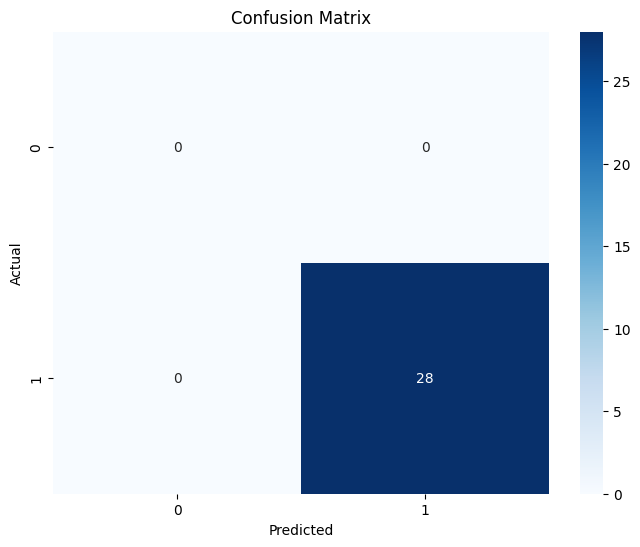

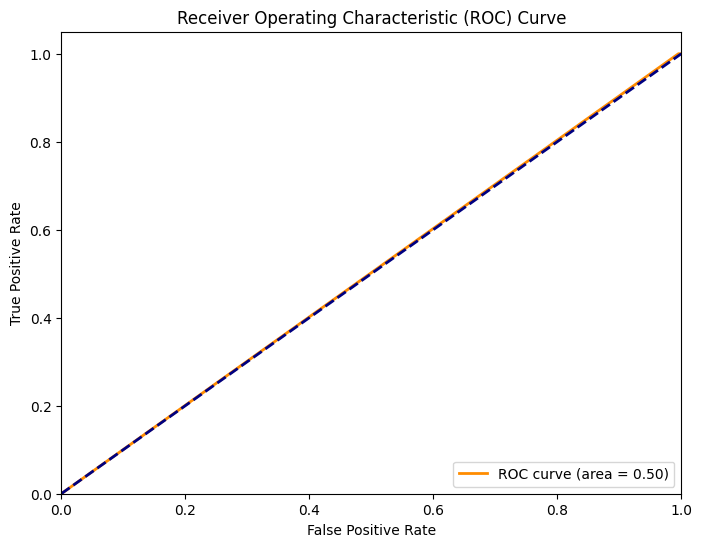

In [90]:
plot_data = train_mixed_effects_model(
    df,
    'ALeisureScore',
    'UniID',
    categorical_controls,
    [
        # 'AFunctionalScore',
        # 'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
    model_type='classification',
)

run_plots(plot_data)

--- Starting Training (Group: UniID) ---
Model Intent: regressor
Preprocessing features...
Falling back to standard GLM/OLS to avoid numeric instability.
Fitting Standard OLS (Regression)...
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1.741
Date:                Mon, 22 Dec 2025   Prob (F-statistic):           1.59e-11
Time:                        23:54:55   Log-Likelihood:                -2710.4
No. Observations:                1855   AIC:                             6027.
Df Residuals:                    1552   BIC:                             7701.
Df Model:                         302                                         
Covariance Type:            nonrobust                                         
                 co

/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [16, 17, 39, 43, 44] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


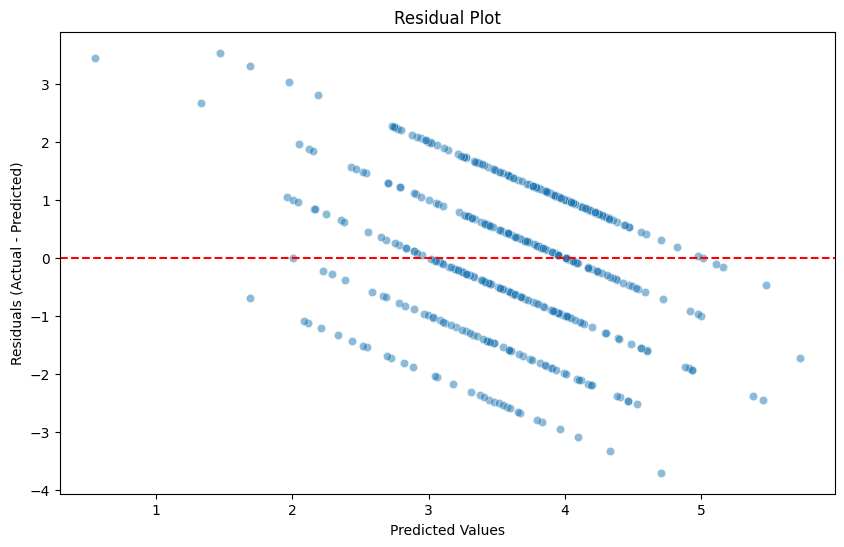

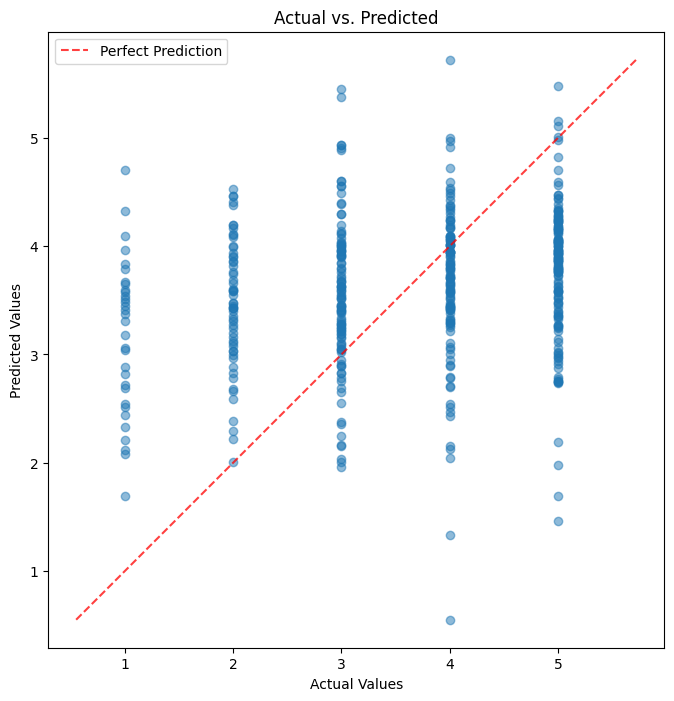

In [91]:
plot_data = train_mixed_effects_model(
    df,
    'ALeisureScore',
    'UniID',  # <--- NEW: Replace with your actual Random Effect / Group column
    categorical_controls,
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
)

run_plots(plot_data)

In [92]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import classification_report

def train_stable_spinal_model(
    df: pd.DataFrame,
    target_col: str,
    random_effect_col: str,
    categorical_cols: List[str],
    continuous_cols: List[str]
) -> Dict[str, Any]:
    
    print(f"--- Training Stable Model (Target: {target_col}) ---")

    # 1. Final Data Cleanup (Drop target/group NAs)
    df_clean = df.dropna(subset=[target_col, random_effect_col]).copy()
    
    # 2. Target Encoding
    if not pd.api.types.is_numeric_dtype(df_clean[target_col]):
        original_categories = df_clean[target_col].astype('category').cat.categories
        labels = list(original_categories) 
        df_clean[target_col] = df_clean[target_col].astype('category').cat.codes
    else:
        labels = [0, 1]

    # 3. Preprocessing Pipeline
    # Using drop='first' is critical for avoiding multicollinearity in GLMs
    preprocessor = ColumnTransformer([
        ('cat', Pipeline([
            ('to_str', FunctionTransformer(lambda x: x.astype(str))),
            ('impute', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
        ]), categorical_cols),
        ('cont', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), continuous_cols)
    ])

    # 4. Stratified Split (Ensures 0/1 balance in test set)
    train_idx, test_idx = train_test_split(
        df_clean.index, test_size=0.2, random_state=42, stratify=df_clean[target_col]
    )
    
    df_train, df_test = df_clean.loc[train_idx], df_clean.loc[test_idx]

    # 5. Transform Features
    X_train = preprocessor.fit_transform(df_train[categorical_cols + continuous_cols])
    X_test = preprocessor.transform(df_test[categorical_cols + continuous_cols])
    
    exog_train = sm.add_constant(X_train, prepend=True)
    exog_test = sm.add_constant(X_test, prepend=True)
    y_train = df_train[target_col].values
    y_test = df_test[target_col].values

    # 6. Fit Regularized GLM (The Stability Fix)
    # alpha=1.0 is the penalty. If you still see overflow, increase this to 5.0 or 10.0
    print("Fitting GLM with L2 Regularization...")
    model_sm = sm.GLM(y_train, exog_train, family=sm.families.Binomial())
    
    try:
        # L1_wt=0 makes it a Ridge (L2) regression
        fitted_model = model_sm.fit_regularized(alpha=1.0, L1_wt=0)
        
        # 7. Generate Predictions for run_plots
        raw_probs = fitted_model.predict(exog_test)
        # Reshape to 2D [Prob_0, Prob_1] to fix the IndexError
        y_pred_proba = np.column_stack((1 - raw_probs, raw_probs))
        y_pred = (raw_probs > 0.5).astype(int)

        print("\n--- Evaluation ---")
        print(classification_report(y_test, y_pred))

        return {
            "model_type": "classifier",
            "y_test": y_test,
            "y_pred": y_pred,
            "y_pred_proba": y_pred_proba,
            "model": fitted_model,
            "labels": labels,
            "preprocessor": preprocessor
        }
    except Exception as e:
        print(f"Model failed to converge: {e}")
        return None

--- Training Stable Model (Target: ALeisureScore) ---
Fitting GLM with L2 Regularization...

--- Evaluation ---
              precision    recall  f1-score   support

         1.0       0.06      1.00      0.11        28
         2.0       0.00      0.00      0.00        56
         3.0       0.00      0.00      0.00       113
         4.0       0.00      0.00      0.00       117
         5.0       0.00      0.00      0.00       150

    accuracy                           0.06       464
   macro avg       0.01      0.20      0.02       464
weighted avg       0.00      0.06      0.01       464



/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [44, 48] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/scipy/optimize/_linesearch.py:161: RuntimeWarning: invalid value encountered in scalar subtract
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/statsmodels/genmod/generalized_linear_model.py:1492: UserWarning: GLM ridge optimization may have failed, |grad|=1.151916
  warnings.warn(msg)
/Users/imene/src/spinal/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/

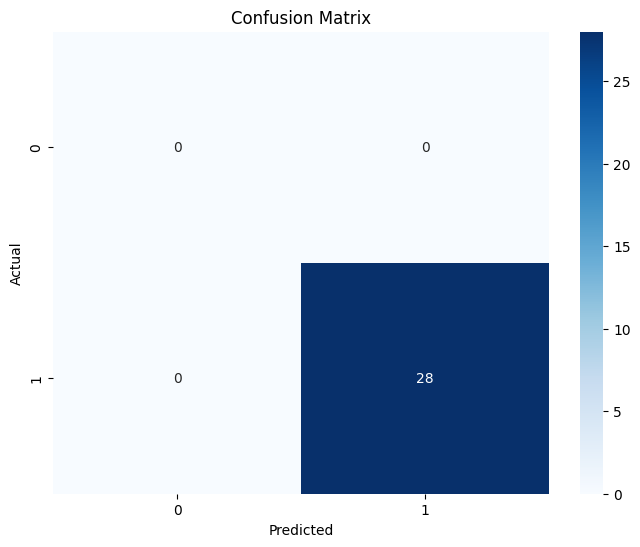

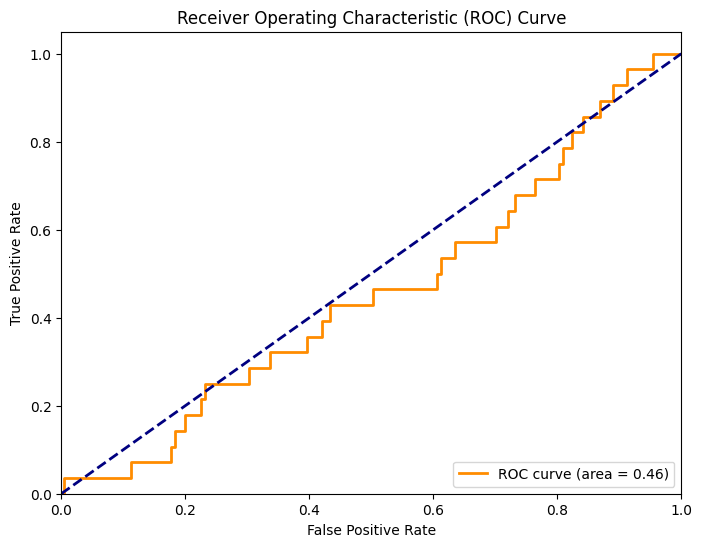

In [95]:
plot_data = train_stable_spinal_model(
    df, 
    'ALeisureScore', 
    'UniID', 
    categorical_controls, 
    [
        'AFunctionalScore',
        'AFunctionalAltScore',
        'AFunctionalAltAltScore',
        'ADepressionScore',
        'AMobilityScore',
        'AIncome',
    ] + list(continuous_controls.keys()),
)

if plot_data:
    run_plots(plot_data)